In [102]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from PIL import Image as I

from imgaug import augmenters as iaa
from torchsummary import summary

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 8

In [104]:
def augmentation(im):
    """
    image: 1, 3, n, n tensor
    
    output: num, 3, n, n tensor
    """
    transformations = [
        iaa.Crop(px=(0, 10)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
        iaa.Noop()
    ]

    im = im.permute(1, 2, 0).numpy()
    return torch.Tensor([t(image=im) for t in transformations]).permute(0, 3, 1, 2)

In [106]:
# dataset = datasets.ImageFolder(root='./data-nodules2d', transform = transforms.Compose([transforms.ToTensor()]))
dataset = datasets.CIFAR10('.', transform = transforms.Compose([transforms.ToTensor(), augmentation]), download = True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.train_data), len(dataloader)

Files already downloaded and verified


(50000, 6250)

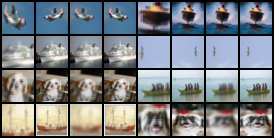

In [107]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

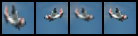

In [108]:
a = fixed_x.view(bs, na, 3, 32, 32)

save_image(a[0], 'real_image.png')
display(Image('real_image.png', width=500, unconfined=True))

### Todo: Totensor --> Numpy --> Totensor

In [293]:
class Net(nn.Module):
    def __init__(self, na=4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)
        
        self.conv4 = nn.Conv2d(32, 16, 3,padding = 1)
        self.conv5 = nn.Conv2d(16, 6, 3,padding = 1)
        self.conv6 = nn.Conv2d(6, 3, 3,padding = 1)
        
        self.na = na

        
    def encoder(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        return x
    
    
    # TODO: Use Fc for pooling    
    def pooling(self, vectors):
        na = self.na
        if not na:
            return vectors
        vectors = vectors.view(bs, na, 128)
        vectors = vectors[:, :na-1, :]
        return vectors.mean(dim=1)
    
    def decoder(self, vector):
        x = self.fc2(vector)
        # 1, 512 --> 1, 32, 4, 4
        x = x.reshape(-1, 32, 4, 4)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv4(x)
        x = F.relu(x)
        
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv5(x)
        x = F.relu(x)

        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv6(x)

        x = torch.sigmoid(x)
        return x
       
        
    def forward(self, x):
        x = x.view(-1, 3, 32, 32)
        x = self.encoder(x)
        x = self.pooling(x)
        y = self.decoder(x)
        return x, y

net = Net()

In [294]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [255]:
# summary(net, (3, 32, 32))

In [308]:
model = Net()
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [350]:
model.na = 4

In [351]:
for param in model.parameters():
    param.requires_grad = True

In [352]:
def train(train_loader, epochs=10):
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            _, I_prime = model(data)

            I = data[:, -1, :]
            l1 = loss(I, I_prime)
            l1.backward()
            optimizer.step()

            if batch_idx % 2 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), l1.item()))

In [ ]:
train(dataloader)

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 0 [0/50000 (0%)]	Loss: 0.019129
Train Epoch: 0 [16/50000 (0%)]	Loss: 0.017755
Train Epoch: 0 [32/50000 (0%)]	Loss: 0.022939
Train Epoch: 0 [48/50000 (0%)]	Loss: 0.022175
Train Epoch: 0 [64/50000 (0%)]	Loss: 0.019460
Train Epoch: 0 [80/50000 (0%)]	Loss: 0.019565
Train Epoch: 0 [96/50000 (0%)]	Loss: 0.015341
Train Epoch: 0 [112/50000 (0%)]	Loss: 0.017698
Train Epoch: 0 [128/50000 (0%)]	Loss: 0.020842
Train Epoch: 0 [144/50000 (0%)]	Loss: 0.019702
Train Epoch: 0 [160/50000 (0%)]	Loss: 0.019217
Train Epoch: 0 [176/50000 (0%)]	Loss: 0.019349
Train Epoch: 0 [192/50000 (0%)]	Loss: 0.021844
Train Epoch: 0 [208/50000 (0%)]	Loss: 0.017010
Train Epoch: 0 [224/50000 (0%)]	Loss: 0.020624
Train Epoch: 0 [240/50000 (0%)]	Loss: 0.015942
Train Epoch: 0 [256/50000 (1%)]	Loss: 0.017373
Train Epoch: 0 [272/50000 (1%)]	Loss: 0.017449
Train Epoch: 0 [288/50000 (1%)]	Loss: 0.021932
Train Epoch: 0 [304/50000 (1%)]	Loss: 0.017016
Train Epoch: 0 [320/50000 (1%)]	Loss: 0.016467
Train Epoch: 0 [336/5

Train Epoch: 0 [2784/50000 (6%)]	Loss: 0.023629
Train Epoch: 0 [2800/50000 (6%)]	Loss: 0.026520
Train Epoch: 0 [2816/50000 (6%)]	Loss: 0.021506
Train Epoch: 0 [2832/50000 (6%)]	Loss: 0.018929
Train Epoch: 0 [2848/50000 (6%)]	Loss: 0.013135
Train Epoch: 0 [2864/50000 (6%)]	Loss: 0.016154
Train Epoch: 0 [2880/50000 (6%)]	Loss: 0.015517
Train Epoch: 0 [2896/50000 (6%)]	Loss: 0.018735
Train Epoch: 0 [2912/50000 (6%)]	Loss: 0.023850
Train Epoch: 0 [2928/50000 (6%)]	Loss: 0.016953
Train Epoch: 0 [2944/50000 (6%)]	Loss: 0.019722
Train Epoch: 0 [2960/50000 (6%)]	Loss: 0.022258
Train Epoch: 0 [2976/50000 (6%)]	Loss: 0.019756
Train Epoch: 0 [2992/50000 (6%)]	Loss: 0.020045
Train Epoch: 0 [3008/50000 (6%)]	Loss: 0.021599
Train Epoch: 0 [3024/50000 (6%)]	Loss: 0.023838
Train Epoch: 0 [3040/50000 (6%)]	Loss: 0.019707
Train Epoch: 0 [3056/50000 (6%)]	Loss: 0.014659
Train Epoch: 0 [3072/50000 (6%)]	Loss: 0.020609
Train Epoch: 0 [3088/50000 (6%)]	Loss: 0.017008
Train Epoch: 0 [3104/50000 (6%)]	Loss: 0

Train Epoch: 0 [5504/50000 (11%)]	Loss: 0.018735
Train Epoch: 0 [5520/50000 (11%)]	Loss: 0.022629
Train Epoch: 0 [5536/50000 (11%)]	Loss: 0.017040
Train Epoch: 0 [5552/50000 (11%)]	Loss: 0.020278
Train Epoch: 0 [5568/50000 (11%)]	Loss: 0.025261
Train Epoch: 0 [5584/50000 (11%)]	Loss: 0.021803
Train Epoch: 0 [5600/50000 (11%)]	Loss: 0.018717
Train Epoch: 0 [5616/50000 (11%)]	Loss: 0.016310
Train Epoch: 0 [5632/50000 (11%)]	Loss: 0.023399
Train Epoch: 0 [5648/50000 (11%)]	Loss: 0.023453
Train Epoch: 0 [5664/50000 (11%)]	Loss: 0.026723
Train Epoch: 0 [5680/50000 (11%)]	Loss: 0.014115
Train Epoch: 0 [5696/50000 (11%)]	Loss: 0.018093
Train Epoch: 0 [5712/50000 (11%)]	Loss: 0.016808
Train Epoch: 0 [5728/50000 (11%)]	Loss: 0.020324
Train Epoch: 0 [5744/50000 (11%)]	Loss: 0.019424
Train Epoch: 0 [5760/50000 (12%)]	Loss: 0.023257
Train Epoch: 0 [5776/50000 (12%)]	Loss: 0.012476
Train Epoch: 0 [5792/50000 (12%)]	Loss: 0.015562
Train Epoch: 0 [5808/50000 (12%)]	Loss: 0.019230
Train Epoch: 0 [5824

Train Epoch: 0 [8192/50000 (16%)]	Loss: 0.022654
Train Epoch: 0 [8208/50000 (16%)]	Loss: 0.021444
Train Epoch: 0 [8224/50000 (16%)]	Loss: 0.018457
Train Epoch: 0 [8240/50000 (16%)]	Loss: 0.015580
Train Epoch: 0 [8256/50000 (17%)]	Loss: 0.021930
Train Epoch: 0 [8272/50000 (17%)]	Loss: 0.021017
Train Epoch: 0 [8288/50000 (17%)]	Loss: 0.017800
Train Epoch: 0 [8304/50000 (17%)]	Loss: 0.012977
Train Epoch: 0 [8320/50000 (17%)]	Loss: 0.023651
Train Epoch: 0 [8336/50000 (17%)]	Loss: 0.016282
Train Epoch: 0 [8352/50000 (17%)]	Loss: 0.018628
Train Epoch: 0 [8368/50000 (17%)]	Loss: 0.022496
Train Epoch: 0 [8384/50000 (17%)]	Loss: 0.030204
Train Epoch: 0 [8400/50000 (17%)]	Loss: 0.018234
Train Epoch: 0 [8416/50000 (17%)]	Loss: 0.016522
Train Epoch: 0 [8432/50000 (17%)]	Loss: 0.018499
Train Epoch: 0 [8448/50000 (17%)]	Loss: 0.015432
Train Epoch: 0 [8464/50000 (17%)]	Loss: 0.021877
Train Epoch: 0 [8480/50000 (17%)]	Loss: 0.018050
Train Epoch: 0 [8496/50000 (17%)]	Loss: 0.024237
Train Epoch: 0 [8512

Train Epoch: 0 [10880/50000 (22%)]	Loss: 0.023199
Train Epoch: 0 [10896/50000 (22%)]	Loss: 0.026736
Train Epoch: 0 [10912/50000 (22%)]	Loss: 0.017129
Train Epoch: 0 [10928/50000 (22%)]	Loss: 0.018361
Train Epoch: 0 [10944/50000 (22%)]	Loss: 0.015177
Train Epoch: 0 [10960/50000 (22%)]	Loss: 0.014545
Train Epoch: 0 [10976/50000 (22%)]	Loss: 0.015094
Train Epoch: 0 [10992/50000 (22%)]	Loss: 0.027489
Train Epoch: 0 [11008/50000 (22%)]	Loss: 0.024450
Train Epoch: 0 [11024/50000 (22%)]	Loss: 0.020945
Train Epoch: 0 [11040/50000 (22%)]	Loss: 0.014646
Train Epoch: 0 [11056/50000 (22%)]	Loss: 0.015825
Train Epoch: 0 [11072/50000 (22%)]	Loss: 0.017757
Train Epoch: 0 [11088/50000 (22%)]	Loss: 0.022287
Train Epoch: 0 [11104/50000 (22%)]	Loss: 0.015884
Train Epoch: 0 [11120/50000 (22%)]	Loss: 0.015863
Train Epoch: 0 [11136/50000 (22%)]	Loss: 0.021459
Train Epoch: 0 [11152/50000 (22%)]	Loss: 0.020403
Train Epoch: 0 [11168/50000 (22%)]	Loss: 0.021809
Train Epoch: 0 [11184/50000 (22%)]	Loss: 0.020426


Train Epoch: 0 [13504/50000 (27%)]	Loss: 0.018072
Train Epoch: 0 [13520/50000 (27%)]	Loss: 0.022874
Train Epoch: 0 [13536/50000 (27%)]	Loss: 0.017014
Train Epoch: 0 [13552/50000 (27%)]	Loss: 0.017957
Train Epoch: 0 [13568/50000 (27%)]	Loss: 0.022724
Train Epoch: 0 [13584/50000 (27%)]	Loss: 0.021104
Train Epoch: 0 [13600/50000 (27%)]	Loss: 0.020177
Train Epoch: 0 [13616/50000 (27%)]	Loss: 0.020969
Train Epoch: 0 [13632/50000 (27%)]	Loss: 0.021204
Train Epoch: 0 [13648/50000 (27%)]	Loss: 0.020034
Train Epoch: 0 [13664/50000 (27%)]	Loss: 0.022796
Train Epoch: 0 [13680/50000 (27%)]	Loss: 0.021331
Train Epoch: 0 [13696/50000 (27%)]	Loss: 0.017288
Train Epoch: 0 [13712/50000 (27%)]	Loss: 0.018152
Train Epoch: 0 [13728/50000 (27%)]	Loss: 0.020165
Train Epoch: 0 [13744/50000 (27%)]	Loss: 0.022932
Train Epoch: 0 [13760/50000 (28%)]	Loss: 0.021240
Train Epoch: 0 [13776/50000 (28%)]	Loss: 0.025473
Train Epoch: 0 [13792/50000 (28%)]	Loss: 0.019315
Train Epoch: 0 [13808/50000 (28%)]	Loss: 0.018347


Train Epoch: 0 [16128/50000 (32%)]	Loss: 0.016864
Train Epoch: 0 [16144/50000 (32%)]	Loss: 0.019310
Train Epoch: 0 [16160/50000 (32%)]	Loss: 0.020342
Train Epoch: 0 [16176/50000 (32%)]	Loss: 0.021587
Train Epoch: 0 [16192/50000 (32%)]	Loss: 0.021647
Train Epoch: 0 [16208/50000 (32%)]	Loss: 0.021060
Train Epoch: 0 [16224/50000 (32%)]	Loss: 0.023317
Train Epoch: 0 [16240/50000 (32%)]	Loss: 0.021999
Train Epoch: 0 [16256/50000 (33%)]	Loss: 0.024608
Train Epoch: 0 [16272/50000 (33%)]	Loss: 0.019595
Train Epoch: 0 [16288/50000 (33%)]	Loss: 0.019373
Train Epoch: 0 [16304/50000 (33%)]	Loss: 0.018779
Train Epoch: 0 [16320/50000 (33%)]	Loss: 0.025364
Train Epoch: 0 [16336/50000 (33%)]	Loss: 0.017650
Train Epoch: 0 [16352/50000 (33%)]	Loss: 0.024216
Train Epoch: 0 [16368/50000 (33%)]	Loss: 0.018075
Train Epoch: 0 [16384/50000 (33%)]	Loss: 0.021883
Train Epoch: 0 [16400/50000 (33%)]	Loss: 0.019463
Train Epoch: 0 [16416/50000 (33%)]	Loss: 0.022078
Train Epoch: 0 [16432/50000 (33%)]	Loss: 0.019692


Train Epoch: 0 [18752/50000 (38%)]	Loss: 0.024386
Train Epoch: 0 [18768/50000 (38%)]	Loss: 0.020544
Train Epoch: 0 [18784/50000 (38%)]	Loss: 0.019674
Train Epoch: 0 [18800/50000 (38%)]	Loss: 0.014710
Train Epoch: 0 [18816/50000 (38%)]	Loss: 0.016042
Train Epoch: 0 [18832/50000 (38%)]	Loss: 0.015725
Train Epoch: 0 [18848/50000 (38%)]	Loss: 0.022928
Train Epoch: 0 [18864/50000 (38%)]	Loss: 0.019717
Train Epoch: 0 [18880/50000 (38%)]	Loss: 0.026659
Train Epoch: 0 [18896/50000 (38%)]	Loss: 0.020979
Train Epoch: 0 [18912/50000 (38%)]	Loss: 0.020608
Train Epoch: 0 [18928/50000 (38%)]	Loss: 0.017213
Train Epoch: 0 [18944/50000 (38%)]	Loss: 0.025928
Train Epoch: 0 [18960/50000 (38%)]	Loss: 0.024972
Train Epoch: 0 [18976/50000 (38%)]	Loss: 0.019597
Train Epoch: 0 [18992/50000 (38%)]	Loss: 0.018629
Train Epoch: 0 [19008/50000 (38%)]	Loss: 0.020924
Train Epoch: 0 [19024/50000 (38%)]	Loss: 0.027219
Train Epoch: 0 [19040/50000 (38%)]	Loss: 0.023667
Train Epoch: 0 [19056/50000 (38%)]	Loss: 0.014881


Train Epoch: 0 [21376/50000 (43%)]	Loss: 0.015014
Train Epoch: 0 [21392/50000 (43%)]	Loss: 0.019618
Train Epoch: 0 [21408/50000 (43%)]	Loss: 0.020383
Train Epoch: 0 [21424/50000 (43%)]	Loss: 0.016786
Train Epoch: 0 [21440/50000 (43%)]	Loss: 0.023684
Train Epoch: 0 [21456/50000 (43%)]	Loss: 0.015516
Train Epoch: 0 [21472/50000 (43%)]	Loss: 0.022322
Train Epoch: 0 [21488/50000 (43%)]	Loss: 0.018786
Train Epoch: 0 [21504/50000 (43%)]	Loss: 0.027262
Train Epoch: 0 [21520/50000 (43%)]	Loss: 0.015715
Train Epoch: 0 [21536/50000 (43%)]	Loss: 0.016504
Train Epoch: 0 [21552/50000 (43%)]	Loss: 0.022917
Train Epoch: 0 [21568/50000 (43%)]	Loss: 0.015375
Train Epoch: 0 [21584/50000 (43%)]	Loss: 0.020775
Train Epoch: 0 [21600/50000 (43%)]	Loss: 0.021140
Train Epoch: 0 [21616/50000 (43%)]	Loss: 0.019403
Train Epoch: 0 [21632/50000 (43%)]	Loss: 0.016903
Train Epoch: 0 [21648/50000 (43%)]	Loss: 0.013847
Train Epoch: 0 [21664/50000 (43%)]	Loss: 0.016117
Train Epoch: 0 [21680/50000 (43%)]	Loss: 0.022077


Train Epoch: 0 [24000/50000 (48%)]	Loss: 0.018061
Train Epoch: 0 [24016/50000 (48%)]	Loss: 0.016048
Train Epoch: 0 [24032/50000 (48%)]	Loss: 0.020265
Train Epoch: 0 [24048/50000 (48%)]	Loss: 0.019599
Train Epoch: 0 [24064/50000 (48%)]	Loss: 0.017587
Train Epoch: 0 [24080/50000 (48%)]	Loss: 0.022423
Train Epoch: 0 [24096/50000 (48%)]	Loss: 0.016631
Train Epoch: 0 [24112/50000 (48%)]	Loss: 0.027036
Train Epoch: 0 [24128/50000 (48%)]	Loss: 0.027133
Train Epoch: 0 [24144/50000 (48%)]	Loss: 0.016038
Train Epoch: 0 [24160/50000 (48%)]	Loss: 0.018259
Train Epoch: 0 [24176/50000 (48%)]	Loss: 0.021483
Train Epoch: 0 [24192/50000 (48%)]	Loss: 0.016795
Train Epoch: 0 [24208/50000 (48%)]	Loss: 0.016776
Train Epoch: 0 [24224/50000 (48%)]	Loss: 0.019380
Train Epoch: 0 [24240/50000 (48%)]	Loss: 0.021440
Train Epoch: 0 [24256/50000 (49%)]	Loss: 0.014697
Train Epoch: 0 [24272/50000 (49%)]	Loss: 0.016999
Train Epoch: 0 [24288/50000 (49%)]	Loss: 0.016863
Train Epoch: 0 [24304/50000 (49%)]	Loss: 0.021498


Train Epoch: 0 [26624/50000 (53%)]	Loss: 0.020353
Train Epoch: 0 [26640/50000 (53%)]	Loss: 0.025139
Train Epoch: 0 [26656/50000 (53%)]	Loss: 0.028223
Train Epoch: 0 [26672/50000 (53%)]	Loss: 0.015454
Train Epoch: 0 [26688/50000 (53%)]	Loss: 0.011684
Train Epoch: 0 [26704/50000 (53%)]	Loss: 0.022035
Train Epoch: 0 [26720/50000 (53%)]	Loss: 0.020644
Train Epoch: 0 [26736/50000 (53%)]	Loss: 0.023939
Train Epoch: 0 [26752/50000 (54%)]	Loss: 0.014837
Train Epoch: 0 [26768/50000 (54%)]	Loss: 0.020222
Train Epoch: 0 [26784/50000 (54%)]	Loss: 0.018298
Train Epoch: 0 [26800/50000 (54%)]	Loss: 0.015796
Train Epoch: 0 [26816/50000 (54%)]	Loss: 0.014471
Train Epoch: 0 [26832/50000 (54%)]	Loss: 0.023245
Train Epoch: 0 [26848/50000 (54%)]	Loss: 0.017084
Train Epoch: 0 [26864/50000 (54%)]	Loss: 0.019288
Train Epoch: 0 [26880/50000 (54%)]	Loss: 0.018861
Train Epoch: 0 [26896/50000 (54%)]	Loss: 0.019120
Train Epoch: 0 [26912/50000 (54%)]	Loss: 0.026030
Train Epoch: 0 [26928/50000 (54%)]	Loss: 0.022096


Train Epoch: 0 [29248/50000 (58%)]	Loss: 0.012885
Train Epoch: 0 [29264/50000 (59%)]	Loss: 0.019222
Train Epoch: 0 [29280/50000 (59%)]	Loss: 0.013927
Train Epoch: 0 [29296/50000 (59%)]	Loss: 0.016781
Train Epoch: 0 [29312/50000 (59%)]	Loss: 0.017500
Train Epoch: 0 [29328/50000 (59%)]	Loss: 0.019369
Train Epoch: 0 [29344/50000 (59%)]	Loss: 0.016488
Train Epoch: 0 [29360/50000 (59%)]	Loss: 0.014399
Train Epoch: 0 [29376/50000 (59%)]	Loss: 0.017674
Train Epoch: 0 [29392/50000 (59%)]	Loss: 0.017917
Train Epoch: 0 [29408/50000 (59%)]	Loss: 0.017758
Train Epoch: 0 [29424/50000 (59%)]	Loss: 0.019063
Train Epoch: 0 [29440/50000 (59%)]	Loss: 0.020573
Train Epoch: 0 [29456/50000 (59%)]	Loss: 0.019295
Train Epoch: 0 [29472/50000 (59%)]	Loss: 0.018962
Train Epoch: 0 [29488/50000 (59%)]	Loss: 0.021772
Train Epoch: 0 [29504/50000 (59%)]	Loss: 0.016838
Train Epoch: 0 [29520/50000 (59%)]	Loss: 0.023357
Train Epoch: 0 [29536/50000 (59%)]	Loss: 0.019981
Train Epoch: 0 [29552/50000 (59%)]	Loss: 0.022640


Train Epoch: 0 [31872/50000 (64%)]	Loss: 0.016927
Train Epoch: 0 [31888/50000 (64%)]	Loss: 0.017851
Train Epoch: 0 [31904/50000 (64%)]	Loss: 0.018751
Train Epoch: 0 [31920/50000 (64%)]	Loss: 0.015761
Train Epoch: 0 [31936/50000 (64%)]	Loss: 0.027036
Train Epoch: 0 [31952/50000 (64%)]	Loss: 0.015033
Train Epoch: 0 [31968/50000 (64%)]	Loss: 0.015248
Train Epoch: 0 [31984/50000 (64%)]	Loss: 0.011849
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.017752
Train Epoch: 0 [32016/50000 (64%)]	Loss: 0.018041
Train Epoch: 0 [32032/50000 (64%)]	Loss: 0.022605
Train Epoch: 0 [32048/50000 (64%)]	Loss: 0.016879
Train Epoch: 0 [32064/50000 (64%)]	Loss: 0.015427
Train Epoch: 0 [32080/50000 (64%)]	Loss: 0.027500
Train Epoch: 0 [32096/50000 (64%)]	Loss: 0.015982
Train Epoch: 0 [32112/50000 (64%)]	Loss: 0.018333
Train Epoch: 0 [32128/50000 (64%)]	Loss: 0.016425
Train Epoch: 0 [32144/50000 (64%)]	Loss: 0.014030
Train Epoch: 0 [32160/50000 (64%)]	Loss: 0.018201
Train Epoch: 0 [32176/50000 (64%)]	Loss: 0.020690


Train Epoch: 0 [34496/50000 (69%)]	Loss: 0.022359
Train Epoch: 0 [34512/50000 (69%)]	Loss: 0.019492
Train Epoch: 0 [34528/50000 (69%)]	Loss: 0.019828
Train Epoch: 0 [34544/50000 (69%)]	Loss: 0.019639
Train Epoch: 0 [34560/50000 (69%)]	Loss: 0.018453
Train Epoch: 0 [34576/50000 (69%)]	Loss: 0.027017
Train Epoch: 0 [34592/50000 (69%)]	Loss: 0.018315
Train Epoch: 0 [34608/50000 (69%)]	Loss: 0.017639
Train Epoch: 0 [34624/50000 (69%)]	Loss: 0.019821
Train Epoch: 0 [34640/50000 (69%)]	Loss: 0.020864
Train Epoch: 0 [34656/50000 (69%)]	Loss: 0.014050
Train Epoch: 0 [34672/50000 (69%)]	Loss: 0.020089
Train Epoch: 0 [34688/50000 (69%)]	Loss: 0.017443
Train Epoch: 0 [34704/50000 (69%)]	Loss: 0.016660
Train Epoch: 0 [34720/50000 (69%)]	Loss: 0.021717
Train Epoch: 0 [34736/50000 (69%)]	Loss: 0.022987
Train Epoch: 0 [34752/50000 (70%)]	Loss: 0.016420
Train Epoch: 0 [34768/50000 (70%)]	Loss: 0.016985
Train Epoch: 0 [34784/50000 (70%)]	Loss: 0.020466
Train Epoch: 0 [34800/50000 (70%)]	Loss: 0.019522


Train Epoch: 0 [37120/50000 (74%)]	Loss: 0.016194
Train Epoch: 0 [37136/50000 (74%)]	Loss: 0.012216
Train Epoch: 0 [37152/50000 (74%)]	Loss: 0.016704
Train Epoch: 0 [37168/50000 (74%)]	Loss: 0.014123
Train Epoch: 0 [37184/50000 (74%)]	Loss: 0.019584
Train Epoch: 0 [37200/50000 (74%)]	Loss: 0.014049
Train Epoch: 0 [37216/50000 (74%)]	Loss: 0.024397
Train Epoch: 0 [37232/50000 (74%)]	Loss: 0.023533
Train Epoch: 0 [37248/50000 (74%)]	Loss: 0.014814
Train Epoch: 0 [37264/50000 (75%)]	Loss: 0.019050
Train Epoch: 0 [37280/50000 (75%)]	Loss: 0.017077
Train Epoch: 0 [37296/50000 (75%)]	Loss: 0.015830
Train Epoch: 0 [37312/50000 (75%)]	Loss: 0.012609
Train Epoch: 0 [37328/50000 (75%)]	Loss: 0.016208
Train Epoch: 0 [37344/50000 (75%)]	Loss: 0.018801
Train Epoch: 0 [37360/50000 (75%)]	Loss: 0.014329
Train Epoch: 0 [37376/50000 (75%)]	Loss: 0.015663
Train Epoch: 0 [37392/50000 (75%)]	Loss: 0.023177
Train Epoch: 0 [37408/50000 (75%)]	Loss: 0.016908
Train Epoch: 0 [37424/50000 (75%)]	Loss: 0.018586


Train Epoch: 0 [39744/50000 (79%)]	Loss: 0.026499
Train Epoch: 0 [39760/50000 (80%)]	Loss: 0.020181
Train Epoch: 0 [39776/50000 (80%)]	Loss: 0.014322
Train Epoch: 0 [39792/50000 (80%)]	Loss: 0.018819
Train Epoch: 0 [39808/50000 (80%)]	Loss: 0.016148
Train Epoch: 0 [39824/50000 (80%)]	Loss: 0.019559
Train Epoch: 0 [39840/50000 (80%)]	Loss: 0.015305
Train Epoch: 0 [39856/50000 (80%)]	Loss: 0.026452
Train Epoch: 0 [39872/50000 (80%)]	Loss: 0.015175
Train Epoch: 0 [39888/50000 (80%)]	Loss: 0.016902
Train Epoch: 0 [39904/50000 (80%)]	Loss: 0.013297
Train Epoch: 0 [39920/50000 (80%)]	Loss: 0.028850
Train Epoch: 0 [39936/50000 (80%)]	Loss: 0.020857
Train Epoch: 0 [39952/50000 (80%)]	Loss: 0.019840
Train Epoch: 0 [39968/50000 (80%)]	Loss: 0.020275
Train Epoch: 0 [39984/50000 (80%)]	Loss: 0.023779
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.028936
Train Epoch: 0 [40016/50000 (80%)]	Loss: 0.018652
Train Epoch: 0 [40032/50000 (80%)]	Loss: 0.019523
Train Epoch: 0 [40048/50000 (80%)]	Loss: 0.015911


Train Epoch: 0 [42368/50000 (85%)]	Loss: 0.016476
Train Epoch: 0 [42384/50000 (85%)]	Loss: 0.021766
Train Epoch: 0 [42400/50000 (85%)]	Loss: 0.015957
Train Epoch: 0 [42416/50000 (85%)]	Loss: 0.017413
Train Epoch: 0 [42432/50000 (85%)]	Loss: 0.020974
Train Epoch: 0 [42448/50000 (85%)]	Loss: 0.021014
Train Epoch: 0 [42464/50000 (85%)]	Loss: 0.017563
Train Epoch: 0 [42480/50000 (85%)]	Loss: 0.019288
Train Epoch: 0 [42496/50000 (85%)]	Loss: 0.015108
Train Epoch: 0 [42512/50000 (85%)]	Loss: 0.016909
Train Epoch: 0 [42528/50000 (85%)]	Loss: 0.015944
Train Epoch: 0 [42544/50000 (85%)]	Loss: 0.022838
Train Epoch: 0 [42560/50000 (85%)]	Loss: 0.019229
Train Epoch: 0 [42576/50000 (85%)]	Loss: 0.019749
Train Epoch: 0 [42592/50000 (85%)]	Loss: 0.017348
Train Epoch: 0 [42608/50000 (85%)]	Loss: 0.024827
Train Epoch: 0 [42624/50000 (85%)]	Loss: 0.022967
Train Epoch: 0 [42640/50000 (85%)]	Loss: 0.019918
Train Epoch: 0 [42656/50000 (85%)]	Loss: 0.026177
Train Epoch: 0 [42672/50000 (85%)]	Loss: 0.016370


Train Epoch: 0 [44992/50000 (90%)]	Loss: 0.018673
Train Epoch: 0 [45008/50000 (90%)]	Loss: 0.017539
Train Epoch: 0 [45024/50000 (90%)]	Loss: 0.024316
Train Epoch: 0 [45040/50000 (90%)]	Loss: 0.018390
Train Epoch: 0 [45056/50000 (90%)]	Loss: 0.017475
Train Epoch: 0 [45072/50000 (90%)]	Loss: 0.020441
Train Epoch: 0 [45088/50000 (90%)]	Loss: 0.017182
Train Epoch: 0 [45104/50000 (90%)]	Loss: 0.018600
Train Epoch: 0 [45120/50000 (90%)]	Loss: 0.016947
Train Epoch: 0 [45136/50000 (90%)]	Loss: 0.018863
Train Epoch: 0 [45152/50000 (90%)]	Loss: 0.021055
Train Epoch: 0 [45168/50000 (90%)]	Loss: 0.025687
Train Epoch: 0 [45184/50000 (90%)]	Loss: 0.018030
Train Epoch: 0 [45200/50000 (90%)]	Loss: 0.017786
Train Epoch: 0 [45216/50000 (90%)]	Loss: 0.018731
Train Epoch: 0 [45232/50000 (90%)]	Loss: 0.022206
Train Epoch: 0 [45248/50000 (90%)]	Loss: 0.019110
Train Epoch: 0 [45264/50000 (91%)]	Loss: 0.016143
Train Epoch: 0 [45280/50000 (91%)]	Loss: 0.019333
Train Epoch: 0 [45296/50000 (91%)]	Loss: 0.023363


Train Epoch: 0 [47616/50000 (95%)]	Loss: 0.023661
Train Epoch: 0 [47632/50000 (95%)]	Loss: 0.022524
Train Epoch: 0 [47648/50000 (95%)]	Loss: 0.016849
Train Epoch: 0 [47664/50000 (95%)]	Loss: 0.017854
Train Epoch: 0 [47680/50000 (95%)]	Loss: 0.015576
Train Epoch: 0 [47696/50000 (95%)]	Loss: 0.017061
Train Epoch: 0 [47712/50000 (95%)]	Loss: 0.018864
Train Epoch: 0 [47728/50000 (95%)]	Loss: 0.020665
Train Epoch: 0 [47744/50000 (95%)]	Loss: 0.022321
Train Epoch: 0 [47760/50000 (96%)]	Loss: 0.017299
Train Epoch: 0 [47776/50000 (96%)]	Loss: 0.018150
Train Epoch: 0 [47792/50000 (96%)]	Loss: 0.019097
Train Epoch: 0 [47808/50000 (96%)]	Loss: 0.019729
Train Epoch: 0 [47824/50000 (96%)]	Loss: 0.021077
Train Epoch: 0 [47840/50000 (96%)]	Loss: 0.021370
Train Epoch: 0 [47856/50000 (96%)]	Loss: 0.016714
Train Epoch: 0 [47872/50000 (96%)]	Loss: 0.016849
Train Epoch: 0 [47888/50000 (96%)]	Loss: 0.018364
Train Epoch: 0 [47904/50000 (96%)]	Loss: 0.018193
Train Epoch: 0 [47920/50000 (96%)]	Loss: 0.016205


Train Epoch: 1 [272/50000 (1%)]	Loss: 0.017074
Train Epoch: 1 [288/50000 (1%)]	Loss: 0.015467
Train Epoch: 1 [304/50000 (1%)]	Loss: 0.017311
Train Epoch: 1 [320/50000 (1%)]	Loss: 0.019015
Train Epoch: 1 [336/50000 (1%)]	Loss: 0.016279
Train Epoch: 1 [352/50000 (1%)]	Loss: 0.016548
Train Epoch: 1 [368/50000 (1%)]	Loss: 0.016662
Train Epoch: 1 [384/50000 (1%)]	Loss: 0.019349
Train Epoch: 1 [400/50000 (1%)]	Loss: 0.021424
Train Epoch: 1 [416/50000 (1%)]	Loss: 0.017677
Train Epoch: 1 [432/50000 (1%)]	Loss: 0.024943
Train Epoch: 1 [448/50000 (1%)]	Loss: 0.013727
Train Epoch: 1 [464/50000 (1%)]	Loss: 0.021335
Train Epoch: 1 [480/50000 (1%)]	Loss: 0.019692
Train Epoch: 1 [496/50000 (1%)]	Loss: 0.021802
Train Epoch: 1 [512/50000 (1%)]	Loss: 0.023713
Train Epoch: 1 [528/50000 (1%)]	Loss: 0.021770
Train Epoch: 1 [544/50000 (1%)]	Loss: 0.023934
Train Epoch: 1 [560/50000 (1%)]	Loss: 0.023809
Train Epoch: 1 [576/50000 (1%)]	Loss: 0.017345
Train Epoch: 1 [592/50000 (1%)]	Loss: 0.015527
Train Epoch: 

Train Epoch: 1 [3024/50000 (6%)]	Loss: 0.027994
Train Epoch: 1 [3040/50000 (6%)]	Loss: 0.018905
Train Epoch: 1 [3056/50000 (6%)]	Loss: 0.015285
Train Epoch: 1 [3072/50000 (6%)]	Loss: 0.014730
Train Epoch: 1 [3088/50000 (6%)]	Loss: 0.018292
Train Epoch: 1 [3104/50000 (6%)]	Loss: 0.022393
Train Epoch: 1 [3120/50000 (6%)]	Loss: 0.023036
Train Epoch: 1 [3136/50000 (6%)]	Loss: 0.019964
Train Epoch: 1 [3152/50000 (6%)]	Loss: 0.021462
Train Epoch: 1 [3168/50000 (6%)]	Loss: 0.017935
Train Epoch: 1 [3184/50000 (6%)]	Loss: 0.016154
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.019706
Train Epoch: 1 [3216/50000 (6%)]	Loss: 0.018392
Train Epoch: 1 [3232/50000 (6%)]	Loss: 0.017095
Train Epoch: 1 [3248/50000 (6%)]	Loss: 0.019686
Train Epoch: 1 [3264/50000 (7%)]	Loss: 0.015926
Train Epoch: 1 [3280/50000 (7%)]	Loss: 0.018031
Train Epoch: 1 [3296/50000 (7%)]	Loss: 0.018407
Train Epoch: 1 [3312/50000 (7%)]	Loss: 0.016209
Train Epoch: 1 [3328/50000 (7%)]	Loss: 0.015115
Train Epoch: 1 [3344/50000 (7%)]	Loss: 0

Train Epoch: 1 [5744/50000 (11%)]	Loss: 0.020763
Train Epoch: 1 [5760/50000 (12%)]	Loss: 0.024439
Train Epoch: 1 [5776/50000 (12%)]	Loss: 0.021276
Train Epoch: 1 [5792/50000 (12%)]	Loss: 0.021612
Train Epoch: 1 [5808/50000 (12%)]	Loss: 0.015592
Train Epoch: 1 [5824/50000 (12%)]	Loss: 0.019611
Train Epoch: 1 [5840/50000 (12%)]	Loss: 0.018507
Train Epoch: 1 [5856/50000 (12%)]	Loss: 0.020928
Train Epoch: 1 [5872/50000 (12%)]	Loss: 0.012031
Train Epoch: 1 [5888/50000 (12%)]	Loss: 0.018857
Train Epoch: 1 [5904/50000 (12%)]	Loss: 0.019377
Train Epoch: 1 [5920/50000 (12%)]	Loss: 0.023571
Train Epoch: 1 [5936/50000 (12%)]	Loss: 0.023871
Train Epoch: 1 [5952/50000 (12%)]	Loss: 0.017305
Train Epoch: 1 [5968/50000 (12%)]	Loss: 0.016202
Train Epoch: 1 [5984/50000 (12%)]	Loss: 0.017006
Train Epoch: 1 [6000/50000 (12%)]	Loss: 0.015272
Train Epoch: 1 [6016/50000 (12%)]	Loss: 0.016936
Train Epoch: 1 [6032/50000 (12%)]	Loss: 0.016547
Train Epoch: 1 [6048/50000 (12%)]	Loss: 0.015488
Train Epoch: 1 [6064

Train Epoch: 1 [8432/50000 (17%)]	Loss: 0.013594
Train Epoch: 1 [8448/50000 (17%)]	Loss: 0.013953
Train Epoch: 1 [8464/50000 (17%)]	Loss: 0.016959
Train Epoch: 1 [8480/50000 (17%)]	Loss: 0.022533
Train Epoch: 1 [8496/50000 (17%)]	Loss: 0.027221
Train Epoch: 1 [8512/50000 (17%)]	Loss: 0.020862
Train Epoch: 1 [8528/50000 (17%)]	Loss: 0.022306
Train Epoch: 1 [8544/50000 (17%)]	Loss: 0.012780
Train Epoch: 1 [8560/50000 (17%)]	Loss: 0.020322
Train Epoch: 1 [8576/50000 (17%)]	Loss: 0.020678
Train Epoch: 1 [8592/50000 (17%)]	Loss: 0.022293
Train Epoch: 1 [8608/50000 (17%)]	Loss: 0.020647
Train Epoch: 1 [8624/50000 (17%)]	Loss: 0.021324
Train Epoch: 1 [8640/50000 (17%)]	Loss: 0.016381
Train Epoch: 1 [8656/50000 (17%)]	Loss: 0.017266
Train Epoch: 1 [8672/50000 (17%)]	Loss: 0.020900
Train Epoch: 1 [8688/50000 (17%)]	Loss: 0.017832
Train Epoch: 1 [8704/50000 (17%)]	Loss: 0.017972
Train Epoch: 1 [8720/50000 (17%)]	Loss: 0.014944
Train Epoch: 1 [8736/50000 (17%)]	Loss: 0.016435
Train Epoch: 1 [8752

Train Epoch: 1 [11088/50000 (22%)]	Loss: 0.014471
Train Epoch: 1 [11104/50000 (22%)]	Loss: 0.020484
Train Epoch: 1 [11120/50000 (22%)]	Loss: 0.021740
Train Epoch: 1 [11136/50000 (22%)]	Loss: 0.016208
Train Epoch: 1 [11152/50000 (22%)]	Loss: 0.024019
Train Epoch: 1 [11168/50000 (22%)]	Loss: 0.021039
Train Epoch: 1 [11184/50000 (22%)]	Loss: 0.020944
Train Epoch: 1 [11200/50000 (22%)]	Loss: 0.021499
Train Epoch: 1 [11216/50000 (22%)]	Loss: 0.018204
Train Epoch: 1 [11232/50000 (22%)]	Loss: 0.021021
Train Epoch: 1 [11248/50000 (22%)]	Loss: 0.019068
Train Epoch: 1 [11264/50000 (23%)]	Loss: 0.022199
Train Epoch: 1 [11280/50000 (23%)]	Loss: 0.020961
Train Epoch: 1 [11296/50000 (23%)]	Loss: 0.018176
Train Epoch: 1 [11312/50000 (23%)]	Loss: 0.023602
Train Epoch: 1 [11328/50000 (23%)]	Loss: 0.024709
Train Epoch: 1 [11344/50000 (23%)]	Loss: 0.021149
Train Epoch: 1 [11360/50000 (23%)]	Loss: 0.021826
Train Epoch: 1 [11376/50000 (23%)]	Loss: 0.018073
Train Epoch: 1 [11392/50000 (23%)]	Loss: 0.021030


Train Epoch: 1 [13712/50000 (27%)]	Loss: 0.020119
Train Epoch: 1 [13728/50000 (27%)]	Loss: 0.013485
Train Epoch: 1 [13744/50000 (27%)]	Loss: 0.019418
Train Epoch: 1 [13760/50000 (28%)]	Loss: 0.018527
Train Epoch: 1 [13776/50000 (28%)]	Loss: 0.014944
Train Epoch: 1 [13792/50000 (28%)]	Loss: 0.015612
Train Epoch: 1 [13808/50000 (28%)]	Loss: 0.022414
Train Epoch: 1 [13824/50000 (28%)]	Loss: 0.017220
Train Epoch: 1 [13840/50000 (28%)]	Loss: 0.015528
Train Epoch: 1 [13856/50000 (28%)]	Loss: 0.015539
Train Epoch: 1 [13872/50000 (28%)]	Loss: 0.020243
Train Epoch: 1 [13888/50000 (28%)]	Loss: 0.022111
Train Epoch: 1 [13904/50000 (28%)]	Loss: 0.022654
Train Epoch: 1 [13920/50000 (28%)]	Loss: 0.025892
Train Epoch: 1 [13936/50000 (28%)]	Loss: 0.018391
Train Epoch: 1 [13952/50000 (28%)]	Loss: 0.013396
Train Epoch: 1 [13968/50000 (28%)]	Loss: 0.015993
Train Epoch: 1 [13984/50000 (28%)]	Loss: 0.017471
Train Epoch: 1 [14000/50000 (28%)]	Loss: 0.024082
Train Epoch: 1 [14016/50000 (28%)]	Loss: 0.021077


Train Epoch: 1 [16336/50000 (33%)]	Loss: 0.024996
Train Epoch: 1 [16352/50000 (33%)]	Loss: 0.019560
Train Epoch: 1 [16368/50000 (33%)]	Loss: 0.018295
Train Epoch: 1 [16384/50000 (33%)]	Loss: 0.017533
Train Epoch: 1 [16400/50000 (33%)]	Loss: 0.017523
Train Epoch: 1 [16416/50000 (33%)]	Loss: 0.020398
Train Epoch: 1 [16432/50000 (33%)]	Loss: 0.020507
Train Epoch: 1 [16448/50000 (33%)]	Loss: 0.018952
Train Epoch: 1 [16464/50000 (33%)]	Loss: 0.018148
Train Epoch: 1 [16480/50000 (33%)]	Loss: 0.020330
Train Epoch: 1 [16496/50000 (33%)]	Loss: 0.018155
Train Epoch: 1 [16512/50000 (33%)]	Loss: 0.015269
Train Epoch: 1 [16528/50000 (33%)]	Loss: 0.017863
Train Epoch: 1 [16544/50000 (33%)]	Loss: 0.017565
Train Epoch: 1 [16560/50000 (33%)]	Loss: 0.016568
Train Epoch: 1 [16576/50000 (33%)]	Loss: 0.023913
Train Epoch: 1 [16592/50000 (33%)]	Loss: 0.021035
Train Epoch: 1 [16608/50000 (33%)]	Loss: 0.018846
Train Epoch: 1 [16624/50000 (33%)]	Loss: 0.019061
Train Epoch: 1 [16640/50000 (33%)]	Loss: 0.022588


Train Epoch: 1 [18960/50000 (38%)]	Loss: 0.019337
Train Epoch: 1 [18976/50000 (38%)]	Loss: 0.022336
Train Epoch: 1 [18992/50000 (38%)]	Loss: 0.028681
Train Epoch: 1 [19008/50000 (38%)]	Loss: 0.022295
Train Epoch: 1 [19024/50000 (38%)]	Loss: 0.026065
Train Epoch: 1 [19040/50000 (38%)]	Loss: 0.020119
Train Epoch: 1 [19056/50000 (38%)]	Loss: 0.020885
Train Epoch: 1 [19072/50000 (38%)]	Loss: 0.015015
Train Epoch: 1 [19088/50000 (38%)]	Loss: 0.018272
Train Epoch: 1 [19104/50000 (38%)]	Loss: 0.026477
Train Epoch: 1 [19120/50000 (38%)]	Loss: 0.027478
Train Epoch: 1 [19136/50000 (38%)]	Loss: 0.023542
Train Epoch: 1 [19152/50000 (38%)]	Loss: 0.025943
Train Epoch: 1 [19168/50000 (38%)]	Loss: 0.027808
Train Epoch: 1 [19184/50000 (38%)]	Loss: 0.021335
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.018604
Train Epoch: 1 [19216/50000 (38%)]	Loss: 0.018635
Train Epoch: 1 [19232/50000 (38%)]	Loss: 0.017968
Train Epoch: 1 [19248/50000 (38%)]	Loss: 0.019595
Train Epoch: 1 [19264/50000 (39%)]	Loss: 0.022282


Train Epoch: 1 [21584/50000 (43%)]	Loss: 0.016163
Train Epoch: 1 [21600/50000 (43%)]	Loss: 0.020782
Train Epoch: 1 [21616/50000 (43%)]	Loss: 0.021499
Train Epoch: 1 [21632/50000 (43%)]	Loss: 0.020342
Train Epoch: 1 [21648/50000 (43%)]	Loss: 0.022351
Train Epoch: 1 [21664/50000 (43%)]	Loss: 0.021677
Train Epoch: 1 [21680/50000 (43%)]	Loss: 0.016636
Train Epoch: 1 [21696/50000 (43%)]	Loss: 0.017387
Train Epoch: 1 [21712/50000 (43%)]	Loss: 0.022041
Train Epoch: 1 [21728/50000 (43%)]	Loss: 0.023746
Train Epoch: 1 [21744/50000 (43%)]	Loss: 0.024946
Train Epoch: 1 [21760/50000 (44%)]	Loss: 0.020362
Train Epoch: 1 [21776/50000 (44%)]	Loss: 0.025911
Train Epoch: 1 [21792/50000 (44%)]	Loss: 0.020565
Train Epoch: 1 [21808/50000 (44%)]	Loss: 0.015988
Train Epoch: 1 [21824/50000 (44%)]	Loss: 0.019115
Train Epoch: 1 [21840/50000 (44%)]	Loss: 0.017556
Train Epoch: 1 [21856/50000 (44%)]	Loss: 0.018312
Train Epoch: 1 [21872/50000 (44%)]	Loss: 0.023614
Train Epoch: 1 [21888/50000 (44%)]	Loss: 0.020385


Train Epoch: 1 [24208/50000 (48%)]	Loss: 0.018997
Train Epoch: 1 [24224/50000 (48%)]	Loss: 0.018657
Train Epoch: 1 [24240/50000 (48%)]	Loss: 0.021398
Train Epoch: 1 [24256/50000 (49%)]	Loss: 0.019617
Train Epoch: 1 [24272/50000 (49%)]	Loss: 0.017409
Train Epoch: 1 [24288/50000 (49%)]	Loss: 0.017070
Train Epoch: 1 [24304/50000 (49%)]	Loss: 0.020434
Train Epoch: 1 [24320/50000 (49%)]	Loss: 0.015591
Train Epoch: 1 [24336/50000 (49%)]	Loss: 0.024174
Train Epoch: 1 [24352/50000 (49%)]	Loss: 0.025300
Train Epoch: 1 [24368/50000 (49%)]	Loss: 0.019204
Train Epoch: 1 [24384/50000 (49%)]	Loss: 0.029875
Train Epoch: 1 [24400/50000 (49%)]	Loss: 0.017691
Train Epoch: 1 [24416/50000 (49%)]	Loss: 0.013419
Train Epoch: 1 [24432/50000 (49%)]	Loss: 0.022669
Train Epoch: 1 [24448/50000 (49%)]	Loss: 0.014466
Train Epoch: 1 [24464/50000 (49%)]	Loss: 0.018823
Train Epoch: 1 [24480/50000 (49%)]	Loss: 0.019765
Train Epoch: 1 [24496/50000 (49%)]	Loss: 0.020124
Train Epoch: 1 [24512/50000 (49%)]	Loss: 0.016185


Train Epoch: 1 [26832/50000 (54%)]	Loss: 0.015363
Train Epoch: 1 [26848/50000 (54%)]	Loss: 0.018313
Train Epoch: 1 [26864/50000 (54%)]	Loss: 0.022094
Train Epoch: 1 [26880/50000 (54%)]	Loss: 0.015452
Train Epoch: 1 [26896/50000 (54%)]	Loss: 0.024453
Train Epoch: 1 [26912/50000 (54%)]	Loss: 0.019579
Train Epoch: 1 [26928/50000 (54%)]	Loss: 0.022247
Train Epoch: 1 [26944/50000 (54%)]	Loss: 0.017208
Train Epoch: 1 [26960/50000 (54%)]	Loss: 0.016514
Train Epoch: 1 [26976/50000 (54%)]	Loss: 0.016937
Train Epoch: 1 [26992/50000 (54%)]	Loss: 0.019340
Train Epoch: 1 [27008/50000 (54%)]	Loss: 0.021345
Train Epoch: 1 [27024/50000 (54%)]	Loss: 0.021781
Train Epoch: 1 [27040/50000 (54%)]	Loss: 0.022166
Train Epoch: 1 [27056/50000 (54%)]	Loss: 0.016600
Train Epoch: 1 [27072/50000 (54%)]	Loss: 0.016152
Train Epoch: 1 [27088/50000 (54%)]	Loss: 0.027410
Train Epoch: 1 [27104/50000 (54%)]	Loss: 0.021190
Train Epoch: 1 [27120/50000 (54%)]	Loss: 0.018837
Train Epoch: 1 [27136/50000 (54%)]	Loss: 0.024658


Train Epoch: 1 [29456/50000 (59%)]	Loss: 0.020052
Train Epoch: 1 [29472/50000 (59%)]	Loss: 0.020970
Train Epoch: 1 [29488/50000 (59%)]	Loss: 0.019303
Train Epoch: 1 [29504/50000 (59%)]	Loss: 0.021031
Train Epoch: 1 [29520/50000 (59%)]	Loss: 0.015018
Train Epoch: 1 [29536/50000 (59%)]	Loss: 0.015244
Train Epoch: 1 [29552/50000 (59%)]	Loss: 0.018587
Train Epoch: 1 [29568/50000 (59%)]	Loss: 0.016832
Train Epoch: 1 [29584/50000 (59%)]	Loss: 0.015088
Train Epoch: 1 [29600/50000 (59%)]	Loss: 0.020824
Train Epoch: 1 [29616/50000 (59%)]	Loss: 0.013904
Train Epoch: 1 [29632/50000 (59%)]	Loss: 0.018142
Train Epoch: 1 [29648/50000 (59%)]	Loss: 0.022195
Train Epoch: 1 [29664/50000 (59%)]	Loss: 0.022531
Train Epoch: 1 [29680/50000 (59%)]	Loss: 0.014900
Train Epoch: 1 [29696/50000 (59%)]	Loss: 0.021640
Train Epoch: 1 [29712/50000 (59%)]	Loss: 0.018851
Train Epoch: 1 [29728/50000 (59%)]	Loss: 0.017694
Train Epoch: 1 [29744/50000 (59%)]	Loss: 0.018900
Train Epoch: 1 [29760/50000 (60%)]	Loss: 0.015614


Train Epoch: 1 [32080/50000 (64%)]	Loss: 0.021332
Train Epoch: 1 [32096/50000 (64%)]	Loss: 0.017718
Train Epoch: 1 [32112/50000 (64%)]	Loss: 0.017706
Train Epoch: 1 [32128/50000 (64%)]	Loss: 0.021711
Train Epoch: 1 [32144/50000 (64%)]	Loss: 0.017238
Train Epoch: 1 [32160/50000 (64%)]	Loss: 0.014788
Train Epoch: 1 [32176/50000 (64%)]	Loss: 0.017356
Train Epoch: 1 [32192/50000 (64%)]	Loss: 0.021293
Train Epoch: 1 [32208/50000 (64%)]	Loss: 0.019387
Train Epoch: 1 [32224/50000 (64%)]	Loss: 0.015818
Train Epoch: 1 [32240/50000 (64%)]	Loss: 0.020874
Train Epoch: 1 [32256/50000 (65%)]	Loss: 0.023230
Train Epoch: 1 [32272/50000 (65%)]	Loss: 0.015292
Train Epoch: 1 [32288/50000 (65%)]	Loss: 0.015960
Train Epoch: 1 [32304/50000 (65%)]	Loss: 0.016510
Train Epoch: 1 [32320/50000 (65%)]	Loss: 0.012496
Train Epoch: 1 [32336/50000 (65%)]	Loss: 0.018574
Train Epoch: 1 [32352/50000 (65%)]	Loss: 0.021879
Train Epoch: 1 [32368/50000 (65%)]	Loss: 0.014209
Train Epoch: 1 [32384/50000 (65%)]	Loss: 0.018845


Train Epoch: 1 [34704/50000 (69%)]	Loss: 0.015075
Train Epoch: 1 [34720/50000 (69%)]	Loss: 0.023522
Train Epoch: 1 [34736/50000 (69%)]	Loss: 0.019315
Train Epoch: 1 [34752/50000 (70%)]	Loss: 0.023121
Train Epoch: 1 [34768/50000 (70%)]	Loss: 0.019085
Train Epoch: 1 [34784/50000 (70%)]	Loss: 0.018833
Train Epoch: 1 [34800/50000 (70%)]	Loss: 0.021104
Train Epoch: 1 [34816/50000 (70%)]	Loss: 0.023106
Train Epoch: 1 [34832/50000 (70%)]	Loss: 0.022649
Train Epoch: 1 [34848/50000 (70%)]	Loss: 0.019257
Train Epoch: 1 [34864/50000 (70%)]	Loss: 0.020653
Train Epoch: 1 [34880/50000 (70%)]	Loss: 0.026976
Train Epoch: 1 [34896/50000 (70%)]	Loss: 0.025027
Train Epoch: 1 [34912/50000 (70%)]	Loss: 0.020612
Train Epoch: 1 [34928/50000 (70%)]	Loss: 0.022528
Train Epoch: 1 [34944/50000 (70%)]	Loss: 0.021123
Train Epoch: 1 [34960/50000 (70%)]	Loss: 0.017419
Train Epoch: 1 [34976/50000 (70%)]	Loss: 0.021448
Train Epoch: 1 [34992/50000 (70%)]	Loss: 0.018990
Train Epoch: 1 [35008/50000 (70%)]	Loss: 0.023065


Train Epoch: 1 [37328/50000 (75%)]	Loss: 0.019711
Train Epoch: 1 [37344/50000 (75%)]	Loss: 0.014487
Train Epoch: 1 [37360/50000 (75%)]	Loss: 0.026308
Train Epoch: 1 [37376/50000 (75%)]	Loss: 0.025776
Train Epoch: 1 [37392/50000 (75%)]	Loss: 0.016893
Train Epoch: 1 [37408/50000 (75%)]	Loss: 0.021487
Train Epoch: 1 [37424/50000 (75%)]	Loss: 0.024659
Train Epoch: 1 [37440/50000 (75%)]	Loss: 0.014674
Train Epoch: 1 [37456/50000 (75%)]	Loss: 0.018160
Train Epoch: 1 [37472/50000 (75%)]	Loss: 0.015650
Train Epoch: 1 [37488/50000 (75%)]	Loss: 0.018706
Train Epoch: 1 [37504/50000 (75%)]	Loss: 0.016995
Train Epoch: 1 [37520/50000 (75%)]	Loss: 0.014060
Train Epoch: 1 [37536/50000 (75%)]	Loss: 0.015356
Train Epoch: 1 [37552/50000 (75%)]	Loss: 0.019936
Train Epoch: 1 [37568/50000 (75%)]	Loss: 0.019044
Train Epoch: 1 [37584/50000 (75%)]	Loss: 0.020574
Train Epoch: 1 [37600/50000 (75%)]	Loss: 0.015522
Train Epoch: 1 [37616/50000 (75%)]	Loss: 0.018468
Train Epoch: 1 [37632/50000 (75%)]	Loss: 0.018633


Train Epoch: 1 [39968/50000 (80%)]	Loss: 0.012582
Train Epoch: 1 [39984/50000 (80%)]	Loss: 0.021930
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.020895
Train Epoch: 1 [40016/50000 (80%)]	Loss: 0.018864
Train Epoch: 1 [40032/50000 (80%)]	Loss: 0.023401
Train Epoch: 1 [40048/50000 (80%)]	Loss: 0.018743
Train Epoch: 1 [40064/50000 (80%)]	Loss: 0.025793
Train Epoch: 1 [40080/50000 (80%)]	Loss: 0.020267
Train Epoch: 1 [40096/50000 (80%)]	Loss: 0.018747
Train Epoch: 1 [40112/50000 (80%)]	Loss: 0.015640
Train Epoch: 1 [40128/50000 (80%)]	Loss: 0.019514
Train Epoch: 1 [40144/50000 (80%)]	Loss: 0.021722
Train Epoch: 1 [40160/50000 (80%)]	Loss: 0.021990
Train Epoch: 1 [40176/50000 (80%)]	Loss: 0.020021
Train Epoch: 1 [40192/50000 (80%)]	Loss: 0.018617
Train Epoch: 1 [40208/50000 (80%)]	Loss: 0.019237
Train Epoch: 1 [40224/50000 (80%)]	Loss: 0.020859
Train Epoch: 1 [40240/50000 (80%)]	Loss: 0.018560
Train Epoch: 1 [40256/50000 (81%)]	Loss: 0.021989
Train Epoch: 1 [40272/50000 (81%)]	Loss: 0.022048


Train Epoch: 1 [42592/50000 (85%)]	Loss: 0.023119
Train Epoch: 1 [42608/50000 (85%)]	Loss: 0.020601
Train Epoch: 1 [42624/50000 (85%)]	Loss: 0.031235
Train Epoch: 1 [42640/50000 (85%)]	Loss: 0.025101
Train Epoch: 1 [42656/50000 (85%)]	Loss: 0.017902
Train Epoch: 1 [42672/50000 (85%)]	Loss: 0.015298
Train Epoch: 1 [42688/50000 (85%)]	Loss: 0.017682
Train Epoch: 1 [42704/50000 (85%)]	Loss: 0.019074
Train Epoch: 1 [42720/50000 (85%)]	Loss: 0.015726
Train Epoch: 1 [42736/50000 (85%)]	Loss: 0.018853
Train Epoch: 1 [42752/50000 (86%)]	Loss: 0.017474
Train Epoch: 1 [42768/50000 (86%)]	Loss: 0.019562
Train Epoch: 1 [42784/50000 (86%)]	Loss: 0.019898
Train Epoch: 1 [42800/50000 (86%)]	Loss: 0.017762
Train Epoch: 1 [42816/50000 (86%)]	Loss: 0.021165
Train Epoch: 1 [42832/50000 (86%)]	Loss: 0.016479
Train Epoch: 1 [42848/50000 (86%)]	Loss: 0.017578
Train Epoch: 1 [42864/50000 (86%)]	Loss: 0.025096
Train Epoch: 1 [42880/50000 (86%)]	Loss: 0.014713
Train Epoch: 1 [42896/50000 (86%)]	Loss: 0.024950


Train Epoch: 1 [45216/50000 (90%)]	Loss: 0.016716
Train Epoch: 1 [45232/50000 (90%)]	Loss: 0.017640
Train Epoch: 1 [45248/50000 (90%)]	Loss: 0.024241
Train Epoch: 1 [45264/50000 (91%)]	Loss: 0.022005
Train Epoch: 1 [45280/50000 (91%)]	Loss: 0.015378
Train Epoch: 1 [45296/50000 (91%)]	Loss: 0.018359
Train Epoch: 1 [45312/50000 (91%)]	Loss: 0.017373
Train Epoch: 1 [45328/50000 (91%)]	Loss: 0.025975
Train Epoch: 1 [45344/50000 (91%)]	Loss: 0.022228
Train Epoch: 1 [45360/50000 (91%)]	Loss: 0.016731
Train Epoch: 1 [45376/50000 (91%)]	Loss: 0.019435
Train Epoch: 1 [45392/50000 (91%)]	Loss: 0.017409
Train Epoch: 1 [45408/50000 (91%)]	Loss: 0.020033
Train Epoch: 1 [45424/50000 (91%)]	Loss: 0.021198
Train Epoch: 1 [45440/50000 (91%)]	Loss: 0.022102
Train Epoch: 1 [45456/50000 (91%)]	Loss: 0.019074
Train Epoch: 1 [45472/50000 (91%)]	Loss: 0.016566
Train Epoch: 1 [45488/50000 (91%)]	Loss: 0.018023
Train Epoch: 1 [45504/50000 (91%)]	Loss: 0.021918
Train Epoch: 1 [45520/50000 (91%)]	Loss: 0.023107


Train Epoch: 1 [47840/50000 (96%)]	Loss: 0.014547
Train Epoch: 1 [47856/50000 (96%)]	Loss: 0.016767
Train Epoch: 1 [47872/50000 (96%)]	Loss: 0.018688
Train Epoch: 1 [47888/50000 (96%)]	Loss: 0.014601
Train Epoch: 1 [47904/50000 (96%)]	Loss: 0.016317
Train Epoch: 1 [47920/50000 (96%)]	Loss: 0.021968
Train Epoch: 1 [47936/50000 (96%)]	Loss: 0.018010
Train Epoch: 1 [47952/50000 (96%)]	Loss: 0.021887
Train Epoch: 1 [47968/50000 (96%)]	Loss: 0.025250
Train Epoch: 1 [47984/50000 (96%)]	Loss: 0.021947
Train Epoch: 1 [48000/50000 (96%)]	Loss: 0.022888
Train Epoch: 1 [48016/50000 (96%)]	Loss: 0.015417
Train Epoch: 1 [48032/50000 (96%)]	Loss: 0.017108
Train Epoch: 1 [48048/50000 (96%)]	Loss: 0.019124
Train Epoch: 1 [48064/50000 (96%)]	Loss: 0.017700
Train Epoch: 1 [48080/50000 (96%)]	Loss: 0.017415
Train Epoch: 1 [48096/50000 (96%)]	Loss: 0.014738
Train Epoch: 1 [48112/50000 (96%)]	Loss: 0.017737
Train Epoch: 1 [48128/50000 (96%)]	Loss: 0.020185
Train Epoch: 1 [48144/50000 (96%)]	Loss: 0.015265


Train Epoch: 2 [496/50000 (1%)]	Loss: 0.016389
Train Epoch: 2 [512/50000 (1%)]	Loss: 0.015464
Train Epoch: 2 [528/50000 (1%)]	Loss: 0.018124
Train Epoch: 2 [544/50000 (1%)]	Loss: 0.021680
Train Epoch: 2 [560/50000 (1%)]	Loss: 0.017007
Train Epoch: 2 [576/50000 (1%)]	Loss: 0.021672
Train Epoch: 2 [592/50000 (1%)]	Loss: 0.023320
Train Epoch: 2 [608/50000 (1%)]	Loss: 0.015910
Train Epoch: 2 [624/50000 (1%)]	Loss: 0.022636
Train Epoch: 2 [640/50000 (1%)]	Loss: 0.017473
Train Epoch: 2 [656/50000 (1%)]	Loss: 0.016639
Train Epoch: 2 [672/50000 (1%)]	Loss: 0.027716
Train Epoch: 2 [688/50000 (1%)]	Loss: 0.021043
Train Epoch: 2 [704/50000 (1%)]	Loss: 0.015212
Train Epoch: 2 [720/50000 (1%)]	Loss: 0.014490
Train Epoch: 2 [736/50000 (1%)]	Loss: 0.023045
Train Epoch: 2 [752/50000 (2%)]	Loss: 0.022568
Train Epoch: 2 [768/50000 (2%)]	Loss: 0.022390
Train Epoch: 2 [784/50000 (2%)]	Loss: 0.019602
Train Epoch: 2 [800/50000 (2%)]	Loss: 0.019750
Train Epoch: 2 [816/50000 (2%)]	Loss: 0.021403
Train Epoch: 

Train Epoch: 2 [3248/50000 (6%)]	Loss: 0.025797
Train Epoch: 2 [3264/50000 (7%)]	Loss: 0.020668
Train Epoch: 2 [3280/50000 (7%)]	Loss: 0.017514
Train Epoch: 2 [3296/50000 (7%)]	Loss: 0.022571
Train Epoch: 2 [3312/50000 (7%)]	Loss: 0.023601
Train Epoch: 2 [3328/50000 (7%)]	Loss: 0.015003
Train Epoch: 2 [3344/50000 (7%)]	Loss: 0.020720
Train Epoch: 2 [3360/50000 (7%)]	Loss: 0.015809
Train Epoch: 2 [3376/50000 (7%)]	Loss: 0.024313
Train Epoch: 2 [3392/50000 (7%)]	Loss: 0.018325
Train Epoch: 2 [3408/50000 (7%)]	Loss: 0.018490
Train Epoch: 2 [3424/50000 (7%)]	Loss: 0.020663
Train Epoch: 2 [3440/50000 (7%)]	Loss: 0.020666
Train Epoch: 2 [3456/50000 (7%)]	Loss: 0.016915
Train Epoch: 2 [3472/50000 (7%)]	Loss: 0.017109
Train Epoch: 2 [3488/50000 (7%)]	Loss: 0.022490
Train Epoch: 2 [3504/50000 (7%)]	Loss: 0.022228
Train Epoch: 2 [3520/50000 (7%)]	Loss: 0.023821
Train Epoch: 2 [3536/50000 (7%)]	Loss: 0.018783
Train Epoch: 2 [3552/50000 (7%)]	Loss: 0.019131
Train Epoch: 2 [3568/50000 (7%)]	Loss: 0

Train Epoch: 2 [5968/50000 (12%)]	Loss: 0.021189
Train Epoch: 2 [5984/50000 (12%)]	Loss: 0.020567
Train Epoch: 2 [6000/50000 (12%)]	Loss: 0.015653
Train Epoch: 2 [6016/50000 (12%)]	Loss: 0.013374
Train Epoch: 2 [6032/50000 (12%)]	Loss: 0.016363
Train Epoch: 2 [6048/50000 (12%)]	Loss: 0.021212
Train Epoch: 2 [6064/50000 (12%)]	Loss: 0.020840
Train Epoch: 2 [6080/50000 (12%)]	Loss: 0.021585
Train Epoch: 2 [6096/50000 (12%)]	Loss: 0.019843
Train Epoch: 2 [6112/50000 (12%)]	Loss: 0.021684
Train Epoch: 2 [6128/50000 (12%)]	Loss: 0.020683
Train Epoch: 2 [6144/50000 (12%)]	Loss: 0.019041
Train Epoch: 2 [6160/50000 (12%)]	Loss: 0.022406
Train Epoch: 2 [6176/50000 (12%)]	Loss: 0.018069
Train Epoch: 2 [6192/50000 (12%)]	Loss: 0.018330
Train Epoch: 2 [6208/50000 (12%)]	Loss: 0.024007
Train Epoch: 2 [6224/50000 (12%)]	Loss: 0.019583
Train Epoch: 2 [6240/50000 (12%)]	Loss: 0.020724
Train Epoch: 2 [6256/50000 (13%)]	Loss: 0.014791
Train Epoch: 2 [6272/50000 (13%)]	Loss: 0.022342
Train Epoch: 2 [6288

Train Epoch: 2 [8656/50000 (17%)]	Loss: 0.020202
Train Epoch: 2 [8672/50000 (17%)]	Loss: 0.013000
Train Epoch: 2 [8688/50000 (17%)]	Loss: 0.016665
Train Epoch: 2 [8704/50000 (17%)]	Loss: 0.019679
Train Epoch: 2 [8720/50000 (17%)]	Loss: 0.017733
Train Epoch: 2 [8736/50000 (17%)]	Loss: 0.022774
Train Epoch: 2 [8752/50000 (18%)]	Loss: 0.026269
Train Epoch: 2 [8768/50000 (18%)]	Loss: 0.012447
Train Epoch: 2 [8784/50000 (18%)]	Loss: 0.024420
Train Epoch: 2 [8800/50000 (18%)]	Loss: 0.015425
Train Epoch: 2 [8816/50000 (18%)]	Loss: 0.015068
Train Epoch: 2 [8832/50000 (18%)]	Loss: 0.019262
Train Epoch: 2 [8848/50000 (18%)]	Loss: 0.020387
Train Epoch: 2 [8864/50000 (18%)]	Loss: 0.017291
Train Epoch: 2 [8880/50000 (18%)]	Loss: 0.018240
Train Epoch: 2 [8896/50000 (18%)]	Loss: 0.027089
Train Epoch: 2 [8912/50000 (18%)]	Loss: 0.017192
Train Epoch: 2 [8928/50000 (18%)]	Loss: 0.015805
Train Epoch: 2 [8944/50000 (18%)]	Loss: 0.012813
Train Epoch: 2 [8960/50000 (18%)]	Loss: 0.019915
Train Epoch: 2 [8976

Train Epoch: 2 [11312/50000 (23%)]	Loss: 0.017228
Train Epoch: 2 [11328/50000 (23%)]	Loss: 0.016460
Train Epoch: 2 [11344/50000 (23%)]	Loss: 0.020753
Train Epoch: 2 [11360/50000 (23%)]	Loss: 0.022705
Train Epoch: 2 [11376/50000 (23%)]	Loss: 0.020217
Train Epoch: 2 [11392/50000 (23%)]	Loss: 0.021903
Train Epoch: 2 [11408/50000 (23%)]	Loss: 0.019062
Train Epoch: 2 [11424/50000 (23%)]	Loss: 0.019945
Train Epoch: 2 [11440/50000 (23%)]	Loss: 0.011367
Train Epoch: 2 [11456/50000 (23%)]	Loss: 0.033864
Train Epoch: 2 [11472/50000 (23%)]	Loss: 0.023641
Train Epoch: 2 [11488/50000 (23%)]	Loss: 0.019325
Train Epoch: 2 [11504/50000 (23%)]	Loss: 0.019456
Train Epoch: 2 [11520/50000 (23%)]	Loss: 0.016435
Train Epoch: 2 [11536/50000 (23%)]	Loss: 0.032660
Train Epoch: 2 [11552/50000 (23%)]	Loss: 0.023114
Train Epoch: 2 [11568/50000 (23%)]	Loss: 0.013698
Train Epoch: 2 [11584/50000 (23%)]	Loss: 0.017832
Train Epoch: 2 [11600/50000 (23%)]	Loss: 0.020392
Train Epoch: 2 [11616/50000 (23%)]	Loss: 0.013203


Train Epoch: 2 [13936/50000 (28%)]	Loss: 0.017251
Train Epoch: 2 [13952/50000 (28%)]	Loss: 0.019130
Train Epoch: 2 [13968/50000 (28%)]	Loss: 0.020679
Train Epoch: 2 [13984/50000 (28%)]	Loss: 0.017596
Train Epoch: 2 [14000/50000 (28%)]	Loss: 0.020954
Train Epoch: 2 [14016/50000 (28%)]	Loss: 0.022344
Train Epoch: 2 [14032/50000 (28%)]	Loss: 0.018254
Train Epoch: 2 [14048/50000 (28%)]	Loss: 0.018679
Train Epoch: 2 [14064/50000 (28%)]	Loss: 0.016926
Train Epoch: 2 [14080/50000 (28%)]	Loss: 0.015444
Train Epoch: 2 [14096/50000 (28%)]	Loss: 0.016951
Train Epoch: 2 [14112/50000 (28%)]	Loss: 0.023048
Train Epoch: 2 [14128/50000 (28%)]	Loss: 0.020945
Train Epoch: 2 [14144/50000 (28%)]	Loss: 0.018473
Train Epoch: 2 [14160/50000 (28%)]	Loss: 0.017363
Train Epoch: 2 [14176/50000 (28%)]	Loss: 0.017943
Train Epoch: 2 [14192/50000 (28%)]	Loss: 0.019680
Train Epoch: 2 [14208/50000 (28%)]	Loss: 0.017586
Train Epoch: 2 [14224/50000 (28%)]	Loss: 0.018864
Train Epoch: 2 [14240/50000 (28%)]	Loss: 0.022767


Train Epoch: 2 [16560/50000 (33%)]	Loss: 0.018266
Train Epoch: 2 [16576/50000 (33%)]	Loss: 0.016644
Train Epoch: 2 [16592/50000 (33%)]	Loss: 0.012432
Train Epoch: 2 [16608/50000 (33%)]	Loss: 0.029689
Train Epoch: 2 [16624/50000 (33%)]	Loss: 0.019459
Train Epoch: 2 [16640/50000 (33%)]	Loss: 0.013685
Train Epoch: 2 [16656/50000 (33%)]	Loss: 0.015917
Train Epoch: 2 [16672/50000 (33%)]	Loss: 0.032125
Train Epoch: 2 [16688/50000 (33%)]	Loss: 0.024794
Train Epoch: 2 [16704/50000 (33%)]	Loss: 0.016820
Train Epoch: 2 [16720/50000 (33%)]	Loss: 0.015990
Train Epoch: 2 [16736/50000 (33%)]	Loss: 0.015213
Train Epoch: 2 [16752/50000 (34%)]	Loss: 0.015714
Train Epoch: 2 [16768/50000 (34%)]	Loss: 0.020927
Train Epoch: 2 [16784/50000 (34%)]	Loss: 0.023133
Train Epoch: 2 [16800/50000 (34%)]	Loss: 0.015568
Train Epoch: 2 [16816/50000 (34%)]	Loss: 0.017602
Train Epoch: 2 [16832/50000 (34%)]	Loss: 0.020068
Train Epoch: 2 [16848/50000 (34%)]	Loss: 0.025223
Train Epoch: 2 [16864/50000 (34%)]	Loss: 0.021870


Train Epoch: 2 [19184/50000 (38%)]	Loss: 0.014924
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.019017
Train Epoch: 2 [19216/50000 (38%)]	Loss: 0.016954
Train Epoch: 2 [19232/50000 (38%)]	Loss: 0.017904
Train Epoch: 2 [19248/50000 (38%)]	Loss: 0.016211
Train Epoch: 2 [19264/50000 (39%)]	Loss: 0.018410
Train Epoch: 2 [19280/50000 (39%)]	Loss: 0.021278
Train Epoch: 2 [19296/50000 (39%)]	Loss: 0.027545
Train Epoch: 2 [19312/50000 (39%)]	Loss: 0.021464
Train Epoch: 2 [19328/50000 (39%)]	Loss: 0.023184
Train Epoch: 2 [19344/50000 (39%)]	Loss: 0.011792
Train Epoch: 2 [19360/50000 (39%)]	Loss: 0.019620
Train Epoch: 2 [19376/50000 (39%)]	Loss: 0.013864
Train Epoch: 2 [19392/50000 (39%)]	Loss: 0.019677
Train Epoch: 2 [19408/50000 (39%)]	Loss: 0.022770
Train Epoch: 2 [19424/50000 (39%)]	Loss: 0.024168
Train Epoch: 2 [19440/50000 (39%)]	Loss: 0.025098
Train Epoch: 2 [19456/50000 (39%)]	Loss: 0.025348
Train Epoch: 2 [19472/50000 (39%)]	Loss: 0.021736
Train Epoch: 2 [19488/50000 (39%)]	Loss: 0.017303


Train Epoch: 2 [21808/50000 (44%)]	Loss: 0.013378
Train Epoch: 2 [21824/50000 (44%)]	Loss: 0.017702
Train Epoch: 2 [21840/50000 (44%)]	Loss: 0.015673
Train Epoch: 2 [21856/50000 (44%)]	Loss: 0.020880
Train Epoch: 2 [21872/50000 (44%)]	Loss: 0.022144
Train Epoch: 2 [21888/50000 (44%)]	Loss: 0.021916
Train Epoch: 2 [21904/50000 (44%)]	Loss: 0.016678
Train Epoch: 2 [21920/50000 (44%)]	Loss: 0.024863
Train Epoch: 2 [21936/50000 (44%)]	Loss: 0.020395
Train Epoch: 2 [21952/50000 (44%)]	Loss: 0.020240
Train Epoch: 2 [21968/50000 (44%)]	Loss: 0.018215
Train Epoch: 2 [21984/50000 (44%)]	Loss: 0.023641
Train Epoch: 2 [22000/50000 (44%)]	Loss: 0.018393
Train Epoch: 2 [22016/50000 (44%)]	Loss: 0.019066
Train Epoch: 2 [22032/50000 (44%)]	Loss: 0.017593
Train Epoch: 2 [22048/50000 (44%)]	Loss: 0.018626
Train Epoch: 2 [22064/50000 (44%)]	Loss: 0.020433
Train Epoch: 2 [22080/50000 (44%)]	Loss: 0.017228
Train Epoch: 2 [22096/50000 (44%)]	Loss: 0.017399
Train Epoch: 2 [22112/50000 (44%)]	Loss: 0.017635


Train Epoch: 2 [24432/50000 (49%)]	Loss: 0.021761
Train Epoch: 2 [24448/50000 (49%)]	Loss: 0.020431
Train Epoch: 2 [24464/50000 (49%)]	Loss: 0.023904
Train Epoch: 2 [24480/50000 (49%)]	Loss: 0.019850
Train Epoch: 2 [24496/50000 (49%)]	Loss: 0.017591
Train Epoch: 2 [24512/50000 (49%)]	Loss: 0.021049
Train Epoch: 2 [24528/50000 (49%)]	Loss: 0.020745
Train Epoch: 2 [24544/50000 (49%)]	Loss: 0.014253
Train Epoch: 2 [24560/50000 (49%)]	Loss: 0.018724
Train Epoch: 2 [24576/50000 (49%)]	Loss: 0.026773
Train Epoch: 2 [24592/50000 (49%)]	Loss: 0.018037
Train Epoch: 2 [24608/50000 (49%)]	Loss: 0.017585
Train Epoch: 2 [24624/50000 (49%)]	Loss: 0.020934
Train Epoch: 2 [24640/50000 (49%)]	Loss: 0.022934
Train Epoch: 2 [24656/50000 (49%)]	Loss: 0.017248
Train Epoch: 2 [24672/50000 (49%)]	Loss: 0.015624
Train Epoch: 2 [24688/50000 (49%)]	Loss: 0.023468
Train Epoch: 2 [24704/50000 (49%)]	Loss: 0.013507
Train Epoch: 2 [24720/50000 (49%)]	Loss: 0.017242
Train Epoch: 2 [24736/50000 (49%)]	Loss: 0.018744


Train Epoch: 2 [27056/50000 (54%)]	Loss: 0.019449
Train Epoch: 2 [27072/50000 (54%)]	Loss: 0.015593
Train Epoch: 2 [27088/50000 (54%)]	Loss: 0.017796
Train Epoch: 2 [27104/50000 (54%)]	Loss: 0.017435
Train Epoch: 2 [27120/50000 (54%)]	Loss: 0.018061
Train Epoch: 2 [27136/50000 (54%)]	Loss: 0.017092
Train Epoch: 2 [27152/50000 (54%)]	Loss: 0.022864
Train Epoch: 2 [27168/50000 (54%)]	Loss: 0.020662
Train Epoch: 2 [27184/50000 (54%)]	Loss: 0.025552
Train Epoch: 2 [27200/50000 (54%)]	Loss: 0.019753
Train Epoch: 2 [27216/50000 (54%)]	Loss: 0.019620
Train Epoch: 2 [27232/50000 (54%)]	Loss: 0.012850
Train Epoch: 2 [27248/50000 (54%)]	Loss: 0.025512
Train Epoch: 2 [27264/50000 (55%)]	Loss: 0.017498
Train Epoch: 2 [27280/50000 (55%)]	Loss: 0.025967
Train Epoch: 2 [27296/50000 (55%)]	Loss: 0.021307
Train Epoch: 2 [27312/50000 (55%)]	Loss: 0.019782
Train Epoch: 2 [27328/50000 (55%)]	Loss: 0.014710
Train Epoch: 2 [27344/50000 (55%)]	Loss: 0.019007
Train Epoch: 2 [27360/50000 (55%)]	Loss: 0.017270


Train Epoch: 2 [29680/50000 (59%)]	Loss: 0.013918
Train Epoch: 2 [29696/50000 (59%)]	Loss: 0.022603
Train Epoch: 2 [29712/50000 (59%)]	Loss: 0.018906
Train Epoch: 2 [29728/50000 (59%)]	Loss: 0.023846
Train Epoch: 2 [29744/50000 (59%)]	Loss: 0.015460
Train Epoch: 2 [29760/50000 (60%)]	Loss: 0.017723
Train Epoch: 2 [29776/50000 (60%)]	Loss: 0.016607
Train Epoch: 2 [29792/50000 (60%)]	Loss: 0.020930
Train Epoch: 2 [29808/50000 (60%)]	Loss: 0.016811
Train Epoch: 2 [29824/50000 (60%)]	Loss: 0.022263
Train Epoch: 2 [29840/50000 (60%)]	Loss: 0.019112
Train Epoch: 2 [29856/50000 (60%)]	Loss: 0.017163
Train Epoch: 2 [29872/50000 (60%)]	Loss: 0.016241
Train Epoch: 2 [29888/50000 (60%)]	Loss: 0.019958
Train Epoch: 2 [29904/50000 (60%)]	Loss: 0.019038
Train Epoch: 2 [29920/50000 (60%)]	Loss: 0.024747
Train Epoch: 2 [29936/50000 (60%)]	Loss: 0.022779
Train Epoch: 2 [29952/50000 (60%)]	Loss: 0.016182
Train Epoch: 2 [29968/50000 (60%)]	Loss: 0.019379
Train Epoch: 2 [29984/50000 (60%)]	Loss: 0.019701


Train Epoch: 2 [32304/50000 (65%)]	Loss: 0.021979
Train Epoch: 2 [32320/50000 (65%)]	Loss: 0.019492
Train Epoch: 2 [32336/50000 (65%)]	Loss: 0.022791
Train Epoch: 2 [32352/50000 (65%)]	Loss: 0.022190
Train Epoch: 2 [32368/50000 (65%)]	Loss: 0.021146
Train Epoch: 2 [32384/50000 (65%)]	Loss: 0.016030
Train Epoch: 2 [32400/50000 (65%)]	Loss: 0.022869
Train Epoch: 2 [32416/50000 (65%)]	Loss: 0.023831
Train Epoch: 2 [32432/50000 (65%)]	Loss: 0.028312
Train Epoch: 2 [32448/50000 (65%)]	Loss: 0.025747
Train Epoch: 2 [32464/50000 (65%)]	Loss: 0.018335
Train Epoch: 2 [32480/50000 (65%)]	Loss: 0.015407
Train Epoch: 2 [32496/50000 (65%)]	Loss: 0.017690
Train Epoch: 2 [32512/50000 (65%)]	Loss: 0.017282
Train Epoch: 2 [32528/50000 (65%)]	Loss: 0.017761
Train Epoch: 2 [32544/50000 (65%)]	Loss: 0.020751
Train Epoch: 2 [32560/50000 (65%)]	Loss: 0.022957
Train Epoch: 2 [32576/50000 (65%)]	Loss: 0.022376
Train Epoch: 2 [32592/50000 (65%)]	Loss: 0.023977
Train Epoch: 2 [32608/50000 (65%)]	Loss: 0.022746


Train Epoch: 2 [34928/50000 (70%)]	Loss: 0.019247
Train Epoch: 2 [34944/50000 (70%)]	Loss: 0.021194
Train Epoch: 2 [34960/50000 (70%)]	Loss: 0.020843
Train Epoch: 2 [34976/50000 (70%)]	Loss: 0.024399
Train Epoch: 2 [34992/50000 (70%)]	Loss: 0.019774
Train Epoch: 2 [35008/50000 (70%)]	Loss: 0.022497
Train Epoch: 2 [35024/50000 (70%)]	Loss: 0.017763
Train Epoch: 2 [35040/50000 (70%)]	Loss: 0.023295
Train Epoch: 2 [35056/50000 (70%)]	Loss: 0.024049
Train Epoch: 2 [35072/50000 (70%)]	Loss: 0.016582
Train Epoch: 2 [35088/50000 (70%)]	Loss: 0.018507
Train Epoch: 2 [35104/50000 (70%)]	Loss: 0.024700
Train Epoch: 2 [35120/50000 (70%)]	Loss: 0.016306
Train Epoch: 2 [35136/50000 (70%)]	Loss: 0.018516
Train Epoch: 2 [35152/50000 (70%)]	Loss: 0.018455
Train Epoch: 2 [35168/50000 (70%)]	Loss: 0.020586
Train Epoch: 2 [35184/50000 (70%)]	Loss: 0.021327
Train Epoch: 2 [35200/50000 (70%)]	Loss: 0.017488
Train Epoch: 2 [35216/50000 (70%)]	Loss: 0.013518
Train Epoch: 2 [35232/50000 (70%)]	Loss: 0.021635


Train Epoch: 2 [37552/50000 (75%)]	Loss: 0.023933
Train Epoch: 2 [37568/50000 (75%)]	Loss: 0.015484
Train Epoch: 2 [37584/50000 (75%)]	Loss: 0.015042
Train Epoch: 2 [37600/50000 (75%)]	Loss: 0.017776
Train Epoch: 2 [37616/50000 (75%)]	Loss: 0.022158
Train Epoch: 2 [37632/50000 (75%)]	Loss: 0.019050
Train Epoch: 2 [37648/50000 (75%)]	Loss: 0.016143
Train Epoch: 2 [37664/50000 (75%)]	Loss: 0.013311
Train Epoch: 2 [37680/50000 (75%)]	Loss: 0.012669
Train Epoch: 2 [37696/50000 (75%)]	Loss: 0.013514
Train Epoch: 2 [37712/50000 (75%)]	Loss: 0.023878
Train Epoch: 2 [37728/50000 (75%)]	Loss: 0.018186
Train Epoch: 2 [37744/50000 (75%)]	Loss: 0.019656
Train Epoch: 2 [37760/50000 (76%)]	Loss: 0.016740
Train Epoch: 2 [37776/50000 (76%)]	Loss: 0.017711
Train Epoch: 2 [37792/50000 (76%)]	Loss: 0.025890
Train Epoch: 2 [37808/50000 (76%)]	Loss: 0.021191
Train Epoch: 2 [37824/50000 (76%)]	Loss: 0.022225
Train Epoch: 2 [37840/50000 (76%)]	Loss: 0.022528
Train Epoch: 2 [37856/50000 (76%)]	Loss: 0.025787


Train Epoch: 2 [40176/50000 (80%)]	Loss: 0.017656
Train Epoch: 2 [40192/50000 (80%)]	Loss: 0.020844
Train Epoch: 2 [40208/50000 (80%)]	Loss: 0.025180
Train Epoch: 2 [40224/50000 (80%)]	Loss: 0.019881
Train Epoch: 2 [40240/50000 (80%)]	Loss: 0.018489
Train Epoch: 2 [40256/50000 (81%)]	Loss: 0.019714
Train Epoch: 2 [40272/50000 (81%)]	Loss: 0.012946
Train Epoch: 2 [40288/50000 (81%)]	Loss: 0.020601
Train Epoch: 2 [40304/50000 (81%)]	Loss: 0.016172
Train Epoch: 2 [40320/50000 (81%)]	Loss: 0.023149
Train Epoch: 2 [40336/50000 (81%)]	Loss: 0.019189
Train Epoch: 2 [40352/50000 (81%)]	Loss: 0.020559
Train Epoch: 2 [40368/50000 (81%)]	Loss: 0.015497
Train Epoch: 2 [40384/50000 (81%)]	Loss: 0.014661
Train Epoch: 2 [40400/50000 (81%)]	Loss: 0.024763
Train Epoch: 2 [40416/50000 (81%)]	Loss: 0.017831
Train Epoch: 2 [40432/50000 (81%)]	Loss: 0.023394
Train Epoch: 2 [40448/50000 (81%)]	Loss: 0.016808
Train Epoch: 2 [40464/50000 (81%)]	Loss: 0.016615
Train Epoch: 2 [40480/50000 (81%)]	Loss: 0.019130


Train Epoch: 2 [42800/50000 (86%)]	Loss: 0.022589
Train Epoch: 2 [42816/50000 (86%)]	Loss: 0.016681
Train Epoch: 2 [42832/50000 (86%)]	Loss: 0.014511
Train Epoch: 2 [42848/50000 (86%)]	Loss: 0.025944
Train Epoch: 2 [42864/50000 (86%)]	Loss: 0.023383
Train Epoch: 2 [42880/50000 (86%)]	Loss: 0.018851
Train Epoch: 2 [42896/50000 (86%)]	Loss: 0.016442
Train Epoch: 2 [42912/50000 (86%)]	Loss: 0.014407
Train Epoch: 2 [42928/50000 (86%)]	Loss: 0.017125
Train Epoch: 2 [42944/50000 (86%)]	Loss: 0.018470
Train Epoch: 2 [42960/50000 (86%)]	Loss: 0.021745
Train Epoch: 2 [42976/50000 (86%)]	Loss: 0.018725
Train Epoch: 2 [42992/50000 (86%)]	Loss: 0.019773
Train Epoch: 2 [43008/50000 (86%)]	Loss: 0.018464
Train Epoch: 2 [43024/50000 (86%)]	Loss: 0.027718
Train Epoch: 2 [43040/50000 (86%)]	Loss: 0.017964
Train Epoch: 2 [43056/50000 (86%)]	Loss: 0.020074
Train Epoch: 2 [43072/50000 (86%)]	Loss: 0.012979
Train Epoch: 2 [43088/50000 (86%)]	Loss: 0.020390
Train Epoch: 2 [43104/50000 (86%)]	Loss: 0.021212


Train Epoch: 2 [45424/50000 (91%)]	Loss: 0.016172
Train Epoch: 2 [45440/50000 (91%)]	Loss: 0.013412
Train Epoch: 2 [45456/50000 (91%)]	Loss: 0.013481
Train Epoch: 2 [45472/50000 (91%)]	Loss: 0.020021
Train Epoch: 2 [45488/50000 (91%)]	Loss: 0.019813
Train Epoch: 2 [45504/50000 (91%)]	Loss: 0.019054
Train Epoch: 2 [45520/50000 (91%)]	Loss: 0.023682
Train Epoch: 2 [45536/50000 (91%)]	Loss: 0.015584
Train Epoch: 2 [45552/50000 (91%)]	Loss: 0.022859
Train Epoch: 2 [45568/50000 (91%)]	Loss: 0.016908
Train Epoch: 2 [45584/50000 (91%)]	Loss: 0.018569
Train Epoch: 2 [45600/50000 (91%)]	Loss: 0.018147
Train Epoch: 2 [45616/50000 (91%)]	Loss: 0.016539
Train Epoch: 2 [45632/50000 (91%)]	Loss: 0.022317
Train Epoch: 2 [45648/50000 (91%)]	Loss: 0.012676
Train Epoch: 2 [45664/50000 (91%)]	Loss: 0.020387
Train Epoch: 2 [45680/50000 (91%)]	Loss: 0.017513
Train Epoch: 2 [45696/50000 (91%)]	Loss: 0.018698
Train Epoch: 2 [45712/50000 (91%)]	Loss: 0.019768
Train Epoch: 2 [45728/50000 (91%)]	Loss: 0.021245


Train Epoch: 2 [48048/50000 (96%)]	Loss: 0.017143
Train Epoch: 2 [48064/50000 (96%)]	Loss: 0.018367
Train Epoch: 2 [48080/50000 (96%)]	Loss: 0.018185
Train Epoch: 2 [48096/50000 (96%)]	Loss: 0.018225
Train Epoch: 2 [48112/50000 (96%)]	Loss: 0.017973
Train Epoch: 2 [48128/50000 (96%)]	Loss: 0.015604
Train Epoch: 2 [48144/50000 (96%)]	Loss: 0.016141
Train Epoch: 2 [48160/50000 (96%)]	Loss: 0.026776
Train Epoch: 2 [48176/50000 (96%)]	Loss: 0.016549
Train Epoch: 2 [48192/50000 (96%)]	Loss: 0.024259
Train Epoch: 2 [48208/50000 (96%)]	Loss: 0.017147
Train Epoch: 2 [48224/50000 (96%)]	Loss: 0.021848
Train Epoch: 2 [48240/50000 (96%)]	Loss: 0.016570
Train Epoch: 2 [48256/50000 (97%)]	Loss: 0.019238
Train Epoch: 2 [48272/50000 (97%)]	Loss: 0.015961
Train Epoch: 2 [48288/50000 (97%)]	Loss: 0.015911
Train Epoch: 2 [48304/50000 (97%)]	Loss: 0.015520
Train Epoch: 2 [48320/50000 (97%)]	Loss: 0.019085
Train Epoch: 2 [48336/50000 (97%)]	Loss: 0.013793
Train Epoch: 2 [48352/50000 (97%)]	Loss: 0.020744


Train Epoch: 3 [720/50000 (1%)]	Loss: 0.019304
Train Epoch: 3 [736/50000 (1%)]	Loss: 0.019073
Train Epoch: 3 [752/50000 (2%)]	Loss: 0.018684
Train Epoch: 3 [768/50000 (2%)]	Loss: 0.015571
Train Epoch: 3 [784/50000 (2%)]	Loss: 0.024564
Train Epoch: 3 [800/50000 (2%)]	Loss: 0.016322
Train Epoch: 3 [816/50000 (2%)]	Loss: 0.025166
Train Epoch: 3 [832/50000 (2%)]	Loss: 0.012891
Train Epoch: 3 [848/50000 (2%)]	Loss: 0.019068
Train Epoch: 3 [864/50000 (2%)]	Loss: 0.012905
Train Epoch: 3 [880/50000 (2%)]	Loss: 0.016860
Train Epoch: 3 [896/50000 (2%)]	Loss: 0.018973
Train Epoch: 3 [912/50000 (2%)]	Loss: 0.017065
Train Epoch: 3 [928/50000 (2%)]	Loss: 0.016994
Train Epoch: 3 [944/50000 (2%)]	Loss: 0.019547
Train Epoch: 3 [960/50000 (2%)]	Loss: 0.024277
Train Epoch: 3 [976/50000 (2%)]	Loss: 0.022200
Train Epoch: 3 [992/50000 (2%)]	Loss: 0.019972
Train Epoch: 3 [1008/50000 (2%)]	Loss: 0.026738
Train Epoch: 3 [1024/50000 (2%)]	Loss: 0.021577
Train Epoch: 3 [1040/50000 (2%)]	Loss: 0.017909
Train Epoc

Train Epoch: 3 [3472/50000 (7%)]	Loss: 0.019174
Train Epoch: 3 [3488/50000 (7%)]	Loss: 0.021487
Train Epoch: 3 [3504/50000 (7%)]	Loss: 0.019445
Train Epoch: 3 [3520/50000 (7%)]	Loss: 0.023576
Train Epoch: 3 [3536/50000 (7%)]	Loss: 0.022021
Train Epoch: 3 [3552/50000 (7%)]	Loss: 0.018284
Train Epoch: 3 [3568/50000 (7%)]	Loss: 0.027064
Train Epoch: 3 [3584/50000 (7%)]	Loss: 0.021558
Train Epoch: 3 [3600/50000 (7%)]	Loss: 0.014326
Train Epoch: 3 [3616/50000 (7%)]	Loss: 0.022947
Train Epoch: 3 [3632/50000 (7%)]	Loss: 0.015144
Train Epoch: 3 [3648/50000 (7%)]	Loss: 0.016271
Train Epoch: 3 [3664/50000 (7%)]	Loss: 0.015618
Train Epoch: 3 [3680/50000 (7%)]	Loss: 0.013120
Train Epoch: 3 [3696/50000 (7%)]	Loss: 0.013124
Train Epoch: 3 [3712/50000 (7%)]	Loss: 0.018257
Train Epoch: 3 [3728/50000 (7%)]	Loss: 0.018211
Train Epoch: 3 [3744/50000 (7%)]	Loss: 0.016769
Train Epoch: 3 [3760/50000 (8%)]	Loss: 0.018904
Train Epoch: 3 [3776/50000 (8%)]	Loss: 0.024101
Train Epoch: 3 [3792/50000 (8%)]	Loss: 0

Train Epoch: 3 [6176/50000 (12%)]	Loss: 0.021340
Train Epoch: 3 [6192/50000 (12%)]	Loss: 0.019640
Train Epoch: 3 [6208/50000 (12%)]	Loss: 0.022807
Train Epoch: 3 [6224/50000 (12%)]	Loss: 0.021528
Train Epoch: 3 [6240/50000 (12%)]	Loss: 0.022934
Train Epoch: 3 [6256/50000 (13%)]	Loss: 0.011825
Train Epoch: 3 [6272/50000 (13%)]	Loss: 0.020607
Train Epoch: 3 [6288/50000 (13%)]	Loss: 0.021603
Train Epoch: 3 [6304/50000 (13%)]	Loss: 0.018133
Train Epoch: 3 [6320/50000 (13%)]	Loss: 0.022355
Train Epoch: 3 [6336/50000 (13%)]	Loss: 0.016841
Train Epoch: 3 [6352/50000 (13%)]	Loss: 0.024616
Train Epoch: 3 [6368/50000 (13%)]	Loss: 0.022438
Train Epoch: 3 [6384/50000 (13%)]	Loss: 0.019864
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.011666
Train Epoch: 3 [6416/50000 (13%)]	Loss: 0.016824
Train Epoch: 3 [6432/50000 (13%)]	Loss: 0.018116
Train Epoch: 3 [6448/50000 (13%)]	Loss: 0.016267
Train Epoch: 3 [6464/50000 (13%)]	Loss: 0.013772
Train Epoch: 3 [6480/50000 (13%)]	Loss: 0.021196
Train Epoch: 3 [6496

Train Epoch: 3 [8864/50000 (18%)]	Loss: 0.014753
Train Epoch: 3 [8880/50000 (18%)]	Loss: 0.021292
Train Epoch: 3 [8896/50000 (18%)]	Loss: 0.021254
Train Epoch: 3 [8912/50000 (18%)]	Loss: 0.014676
Train Epoch: 3 [8928/50000 (18%)]	Loss: 0.025084
Train Epoch: 3 [8944/50000 (18%)]	Loss: 0.014716
Train Epoch: 3 [8960/50000 (18%)]	Loss: 0.017847
Train Epoch: 3 [8976/50000 (18%)]	Loss: 0.016695
Train Epoch: 3 [8992/50000 (18%)]	Loss: 0.021084
Train Epoch: 3 [9008/50000 (18%)]	Loss: 0.017724
Train Epoch: 3 [9024/50000 (18%)]	Loss: 0.016111
Train Epoch: 3 [9040/50000 (18%)]	Loss: 0.021098
Train Epoch: 3 [9056/50000 (18%)]	Loss: 0.019539
Train Epoch: 3 [9072/50000 (18%)]	Loss: 0.015295
Train Epoch: 3 [9088/50000 (18%)]	Loss: 0.031784
Train Epoch: 3 [9104/50000 (18%)]	Loss: 0.026354
Train Epoch: 3 [9120/50000 (18%)]	Loss: 0.017741
Train Epoch: 3 [9136/50000 (18%)]	Loss: 0.016682
Train Epoch: 3 [9152/50000 (18%)]	Loss: 0.018083
Train Epoch: 3 [9168/50000 (18%)]	Loss: 0.023067
Train Epoch: 3 [9184

Train Epoch: 3 [11520/50000 (23%)]	Loss: 0.021356
Train Epoch: 3 [11536/50000 (23%)]	Loss: 0.026314
Train Epoch: 3 [11552/50000 (23%)]	Loss: 0.017596
Train Epoch: 3 [11568/50000 (23%)]	Loss: 0.013638
Train Epoch: 3 [11584/50000 (23%)]	Loss: 0.021465
Train Epoch: 3 [11600/50000 (23%)]	Loss: 0.021638
Train Epoch: 3 [11616/50000 (23%)]	Loss: 0.022175
Train Epoch: 3 [11632/50000 (23%)]	Loss: 0.021058
Train Epoch: 3 [11648/50000 (23%)]	Loss: 0.022589
Train Epoch: 3 [11664/50000 (23%)]	Loss: 0.022160
Train Epoch: 3 [11680/50000 (23%)]	Loss: 0.021713
Train Epoch: 3 [11696/50000 (23%)]	Loss: 0.022408
Train Epoch: 3 [11712/50000 (23%)]	Loss: 0.023819
Train Epoch: 3 [11728/50000 (23%)]	Loss: 0.020930
Train Epoch: 3 [11744/50000 (23%)]	Loss: 0.020048
Train Epoch: 3 [11760/50000 (24%)]	Loss: 0.026851
Train Epoch: 3 [11776/50000 (24%)]	Loss: 0.022869
Train Epoch: 3 [11792/50000 (24%)]	Loss: 0.022351
Train Epoch: 3 [11808/50000 (24%)]	Loss: 0.018984
Train Epoch: 3 [11824/50000 (24%)]	Loss: 0.017354


Train Epoch: 3 [14144/50000 (28%)]	Loss: 0.028262
Train Epoch: 3 [14160/50000 (28%)]	Loss: 0.025768
Train Epoch: 3 [14176/50000 (28%)]	Loss: 0.016492
Train Epoch: 3 [14192/50000 (28%)]	Loss: 0.016925
Train Epoch: 3 [14208/50000 (28%)]	Loss: 0.021922
Train Epoch: 3 [14224/50000 (28%)]	Loss: 0.021883
Train Epoch: 3 [14240/50000 (28%)]	Loss: 0.019113
Train Epoch: 3 [14256/50000 (29%)]	Loss: 0.016625
Train Epoch: 3 [14272/50000 (29%)]	Loss: 0.017736
Train Epoch: 3 [14288/50000 (29%)]	Loss: 0.026047
Train Epoch: 3 [14304/50000 (29%)]	Loss: 0.019319
Train Epoch: 3 [14320/50000 (29%)]	Loss: 0.022873
Train Epoch: 3 [14336/50000 (29%)]	Loss: 0.016966
Train Epoch: 3 [14352/50000 (29%)]	Loss: 0.018829
Train Epoch: 3 [14368/50000 (29%)]	Loss: 0.021609
Train Epoch: 3 [14384/50000 (29%)]	Loss: 0.018600
Train Epoch: 3 [14400/50000 (29%)]	Loss: 0.021029
Train Epoch: 3 [14416/50000 (29%)]	Loss: 0.017298
Train Epoch: 3 [14432/50000 (29%)]	Loss: 0.013165
Train Epoch: 3 [14448/50000 (29%)]	Loss: 0.021159


Train Epoch: 3 [16768/50000 (34%)]	Loss: 0.018202
Train Epoch: 3 [16784/50000 (34%)]	Loss: 0.020047
Train Epoch: 3 [16800/50000 (34%)]	Loss: 0.014222
Train Epoch: 3 [16816/50000 (34%)]	Loss: 0.017404
Train Epoch: 3 [16832/50000 (34%)]	Loss: 0.015928
Train Epoch: 3 [16848/50000 (34%)]	Loss: 0.022722
Train Epoch: 3 [16864/50000 (34%)]	Loss: 0.021077
Train Epoch: 3 [16880/50000 (34%)]	Loss: 0.020036
Train Epoch: 3 [16896/50000 (34%)]	Loss: 0.020528
Train Epoch: 3 [16912/50000 (34%)]	Loss: 0.014193
Train Epoch: 3 [16928/50000 (34%)]	Loss: 0.022865
Train Epoch: 3 [16944/50000 (34%)]	Loss: 0.017497
Train Epoch: 3 [16960/50000 (34%)]	Loss: 0.017247
Train Epoch: 3 [16976/50000 (34%)]	Loss: 0.018083
Train Epoch: 3 [16992/50000 (34%)]	Loss: 0.017673
Train Epoch: 3 [17008/50000 (34%)]	Loss: 0.020268
Train Epoch: 3 [17024/50000 (34%)]	Loss: 0.017209
Train Epoch: 3 [17040/50000 (34%)]	Loss: 0.027642
Train Epoch: 3 [17056/50000 (34%)]	Loss: 0.022145
Train Epoch: 3 [17072/50000 (34%)]	Loss: 0.019665


Train Epoch: 3 [19392/50000 (39%)]	Loss: 0.019747
Train Epoch: 3 [19408/50000 (39%)]	Loss: 0.022441
Train Epoch: 3 [19424/50000 (39%)]	Loss: 0.015401
Train Epoch: 3 [19440/50000 (39%)]	Loss: 0.027606
Train Epoch: 3 [19456/50000 (39%)]	Loss: 0.019469
Train Epoch: 3 [19472/50000 (39%)]	Loss: 0.017273
Train Epoch: 3 [19488/50000 (39%)]	Loss: 0.021553
Train Epoch: 3 [19504/50000 (39%)]	Loss: 0.025305
Train Epoch: 3 [19520/50000 (39%)]	Loss: 0.015304
Train Epoch: 3 [19536/50000 (39%)]	Loss: 0.021755
Train Epoch: 3 [19552/50000 (39%)]	Loss: 0.019695
Train Epoch: 3 [19568/50000 (39%)]	Loss: 0.021902
Train Epoch: 3 [19584/50000 (39%)]	Loss: 0.022839
Train Epoch: 3 [19600/50000 (39%)]	Loss: 0.020556
Train Epoch: 3 [19616/50000 (39%)]	Loss: 0.018753
Train Epoch: 3 [19632/50000 (39%)]	Loss: 0.018261
Train Epoch: 3 [19648/50000 (39%)]	Loss: 0.016904
Train Epoch: 3 [19664/50000 (39%)]	Loss: 0.022165
Train Epoch: 3 [19680/50000 (39%)]	Loss: 0.013870
Train Epoch: 3 [19696/50000 (39%)]	Loss: 0.017199


Train Epoch: 3 [22016/50000 (44%)]	Loss: 0.021348
Train Epoch: 3 [22032/50000 (44%)]	Loss: 0.016132
Train Epoch: 3 [22048/50000 (44%)]	Loss: 0.021993
Train Epoch: 3 [22064/50000 (44%)]	Loss: 0.020299
Train Epoch: 3 [22080/50000 (44%)]	Loss: 0.024560
Train Epoch: 3 [22096/50000 (44%)]	Loss: 0.019044
Train Epoch: 3 [22112/50000 (44%)]	Loss: 0.021309
Train Epoch: 3 [22128/50000 (44%)]	Loss: 0.019382
Train Epoch: 3 [22144/50000 (44%)]	Loss: 0.015665
Train Epoch: 3 [22160/50000 (44%)]	Loss: 0.017123
Train Epoch: 3 [22176/50000 (44%)]	Loss: 0.019434
Train Epoch: 3 [22192/50000 (44%)]	Loss: 0.021313
Train Epoch: 3 [22208/50000 (44%)]	Loss: 0.034255
Train Epoch: 3 [22224/50000 (44%)]	Loss: 0.017939
Train Epoch: 3 [22240/50000 (44%)]	Loss: 0.017823
Train Epoch: 3 [22256/50000 (45%)]	Loss: 0.020855
Train Epoch: 3 [22272/50000 (45%)]	Loss: 0.014111
Train Epoch: 3 [22288/50000 (45%)]	Loss: 0.021512
Train Epoch: 3 [22304/50000 (45%)]	Loss: 0.025974
Train Epoch: 3 [22320/50000 (45%)]	Loss: 0.014380


Train Epoch: 3 [24640/50000 (49%)]	Loss: 0.012749
Train Epoch: 3 [24656/50000 (49%)]	Loss: 0.021712
Train Epoch: 3 [24672/50000 (49%)]	Loss: 0.017215
Train Epoch: 3 [24688/50000 (49%)]	Loss: 0.016851
Train Epoch: 3 [24704/50000 (49%)]	Loss: 0.020438
Train Epoch: 3 [24720/50000 (49%)]	Loss: 0.021359
Train Epoch: 3 [24736/50000 (49%)]	Loss: 0.023031
Train Epoch: 3 [24752/50000 (50%)]	Loss: 0.017207
Train Epoch: 3 [24768/50000 (50%)]	Loss: 0.016585
Train Epoch: 3 [24784/50000 (50%)]	Loss: 0.015527
Train Epoch: 3 [24800/50000 (50%)]	Loss: 0.018314
Train Epoch: 3 [24816/50000 (50%)]	Loss: 0.019274
Train Epoch: 3 [24832/50000 (50%)]	Loss: 0.018421
Train Epoch: 3 [24848/50000 (50%)]	Loss: 0.023355
Train Epoch: 3 [24864/50000 (50%)]	Loss: 0.024318
Train Epoch: 3 [24880/50000 (50%)]	Loss: 0.020653
Train Epoch: 3 [24896/50000 (50%)]	Loss: 0.022537
Train Epoch: 3 [24912/50000 (50%)]	Loss: 0.025981
Train Epoch: 3 [24928/50000 (50%)]	Loss: 0.017252
Train Epoch: 3 [24944/50000 (50%)]	Loss: 0.019308


Train Epoch: 3 [27264/50000 (55%)]	Loss: 0.024683
Train Epoch: 3 [27280/50000 (55%)]	Loss: 0.016956
Train Epoch: 3 [27296/50000 (55%)]	Loss: 0.017041
Train Epoch: 3 [27312/50000 (55%)]	Loss: 0.018136
Train Epoch: 3 [27328/50000 (55%)]	Loss: 0.020763
Train Epoch: 3 [27344/50000 (55%)]	Loss: 0.015721
Train Epoch: 3 [27360/50000 (55%)]	Loss: 0.019942
Train Epoch: 3 [27376/50000 (55%)]	Loss: 0.013475
Train Epoch: 3 [27392/50000 (55%)]	Loss: 0.016822
Train Epoch: 3 [27408/50000 (55%)]	Loss: 0.015959
Train Epoch: 3 [27424/50000 (55%)]	Loss: 0.018018
Train Epoch: 3 [27440/50000 (55%)]	Loss: 0.015470
Train Epoch: 3 [27456/50000 (55%)]	Loss: 0.019686
Train Epoch: 3 [27472/50000 (55%)]	Loss: 0.016342
Train Epoch: 3 [27488/50000 (55%)]	Loss: 0.023375
Train Epoch: 3 [27504/50000 (55%)]	Loss: 0.017605
Train Epoch: 3 [27520/50000 (55%)]	Loss: 0.020260
Train Epoch: 3 [27536/50000 (55%)]	Loss: 0.022902
Train Epoch: 3 [27552/50000 (55%)]	Loss: 0.020329
Train Epoch: 3 [27568/50000 (55%)]	Loss: 0.025279


Train Epoch: 3 [29888/50000 (60%)]	Loss: 0.015983
Train Epoch: 3 [29904/50000 (60%)]	Loss: 0.017081
Train Epoch: 3 [29920/50000 (60%)]	Loss: 0.017216
Train Epoch: 3 [29936/50000 (60%)]	Loss: 0.019689
Train Epoch: 3 [29952/50000 (60%)]	Loss: 0.026328
Train Epoch: 3 [29968/50000 (60%)]	Loss: 0.018237
Train Epoch: 3 [29984/50000 (60%)]	Loss: 0.019591
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.017177
Train Epoch: 3 [30016/50000 (60%)]	Loss: 0.016600
Train Epoch: 3 [30032/50000 (60%)]	Loss: 0.017283
Train Epoch: 3 [30048/50000 (60%)]	Loss: 0.017398
Train Epoch: 3 [30064/50000 (60%)]	Loss: 0.018516
Train Epoch: 3 [30080/50000 (60%)]	Loss: 0.014459
Train Epoch: 3 [30096/50000 (60%)]	Loss: 0.019540
Train Epoch: 3 [30112/50000 (60%)]	Loss: 0.017870
Train Epoch: 3 [30128/50000 (60%)]	Loss: 0.017819
Train Epoch: 3 [30144/50000 (60%)]	Loss: 0.021291
Train Epoch: 3 [30160/50000 (60%)]	Loss: 0.020999
Train Epoch: 3 [30176/50000 (60%)]	Loss: 0.014038
Train Epoch: 3 [30192/50000 (60%)]	Loss: 0.024853


Train Epoch: 3 [32512/50000 (65%)]	Loss: 0.019423
Train Epoch: 3 [32528/50000 (65%)]	Loss: 0.018488
Train Epoch: 3 [32544/50000 (65%)]	Loss: 0.024671
Train Epoch: 3 [32560/50000 (65%)]	Loss: 0.014991
Train Epoch: 3 [32576/50000 (65%)]	Loss: 0.019717
Train Epoch: 3 [32592/50000 (65%)]	Loss: 0.020936
Train Epoch: 3 [32608/50000 (65%)]	Loss: 0.017167
Train Epoch: 3 [32624/50000 (65%)]	Loss: 0.021850
Train Epoch: 3 [32640/50000 (65%)]	Loss: 0.016708
Train Epoch: 3 [32656/50000 (65%)]	Loss: 0.017084
Train Epoch: 3 [32672/50000 (65%)]	Loss: 0.017723
Train Epoch: 3 [32688/50000 (65%)]	Loss: 0.017937
Train Epoch: 3 [32704/50000 (65%)]	Loss: 0.017585
Train Epoch: 3 [32720/50000 (65%)]	Loss: 0.019314
Train Epoch: 3 [32736/50000 (65%)]	Loss: 0.015760
Train Epoch: 3 [32752/50000 (66%)]	Loss: 0.018038
Train Epoch: 3 [32768/50000 (66%)]	Loss: 0.019486
Train Epoch: 3 [32784/50000 (66%)]	Loss: 0.019250
Train Epoch: 3 [32800/50000 (66%)]	Loss: 0.015124
Train Epoch: 3 [32816/50000 (66%)]	Loss: 0.017971


Train Epoch: 3 [35136/50000 (70%)]	Loss: 0.018088
Train Epoch: 3 [35152/50000 (70%)]	Loss: 0.019258
Train Epoch: 3 [35168/50000 (70%)]	Loss: 0.027141
Train Epoch: 3 [35184/50000 (70%)]	Loss: 0.019291
Train Epoch: 3 [35200/50000 (70%)]	Loss: 0.021141
Train Epoch: 3 [35216/50000 (70%)]	Loss: 0.018688
Train Epoch: 3 [35232/50000 (70%)]	Loss: 0.020511
Train Epoch: 3 [35248/50000 (70%)]	Loss: 0.015801
Train Epoch: 3 [35264/50000 (71%)]	Loss: 0.019074
Train Epoch: 3 [35280/50000 (71%)]	Loss: 0.017196
Train Epoch: 3 [35296/50000 (71%)]	Loss: 0.017704
Train Epoch: 3 [35312/50000 (71%)]	Loss: 0.017498
Train Epoch: 3 [35328/50000 (71%)]	Loss: 0.016176
Train Epoch: 3 [35344/50000 (71%)]	Loss: 0.029315
Train Epoch: 3 [35360/50000 (71%)]	Loss: 0.028497
Train Epoch: 3 [35376/50000 (71%)]	Loss: 0.025099
Train Epoch: 3 [35392/50000 (71%)]	Loss: 0.016723
Train Epoch: 3 [35408/50000 (71%)]	Loss: 0.017388
Train Epoch: 3 [35424/50000 (71%)]	Loss: 0.018364
Train Epoch: 3 [35440/50000 (71%)]	Loss: 0.020636


Train Epoch: 3 [37760/50000 (76%)]	Loss: 0.022753
Train Epoch: 3 [37776/50000 (76%)]	Loss: 0.021951
Train Epoch: 3 [37792/50000 (76%)]	Loss: 0.020447
Train Epoch: 3 [37808/50000 (76%)]	Loss: 0.020703
Train Epoch: 3 [37824/50000 (76%)]	Loss: 0.012879
Train Epoch: 3 [37840/50000 (76%)]	Loss: 0.016483
Train Epoch: 3 [37856/50000 (76%)]	Loss: 0.019410
Train Epoch: 3 [37872/50000 (76%)]	Loss: 0.022579
Train Epoch: 3 [37888/50000 (76%)]	Loss: 0.015075
Train Epoch: 3 [37904/50000 (76%)]	Loss: 0.019191
Train Epoch: 3 [37920/50000 (76%)]	Loss: 0.016017
Train Epoch: 3 [37936/50000 (76%)]	Loss: 0.020934
Train Epoch: 3 [37952/50000 (76%)]	Loss: 0.021769
Train Epoch: 3 [37968/50000 (76%)]	Loss: 0.019922
Train Epoch: 3 [37984/50000 (76%)]	Loss: 0.017888
Train Epoch: 3 [38000/50000 (76%)]	Loss: 0.018296
Train Epoch: 3 [38016/50000 (76%)]	Loss: 0.014726
Train Epoch: 3 [38032/50000 (76%)]	Loss: 0.018079
Train Epoch: 3 [38048/50000 (76%)]	Loss: 0.017644
Train Epoch: 3 [38064/50000 (76%)]	Loss: 0.017538


Train Epoch: 3 [40384/50000 (81%)]	Loss: 0.022684
Train Epoch: 3 [40400/50000 (81%)]	Loss: 0.012430
Train Epoch: 3 [40416/50000 (81%)]	Loss: 0.019276
Train Epoch: 3 [40432/50000 (81%)]	Loss: 0.022572
Train Epoch: 3 [40448/50000 (81%)]	Loss: 0.015589
Train Epoch: 3 [40464/50000 (81%)]	Loss: 0.019431
Train Epoch: 3 [40480/50000 (81%)]	Loss: 0.022887
Train Epoch: 3 [40496/50000 (81%)]	Loss: 0.021501
Train Epoch: 3 [40512/50000 (81%)]	Loss: 0.015539
Train Epoch: 3 [40528/50000 (81%)]	Loss: 0.023046
Train Epoch: 3 [40544/50000 (81%)]	Loss: 0.020621
Train Epoch: 3 [40560/50000 (81%)]	Loss: 0.018497
Train Epoch: 3 [40576/50000 (81%)]	Loss: 0.025299
Train Epoch: 3 [40592/50000 (81%)]	Loss: 0.018370
Train Epoch: 3 [40608/50000 (81%)]	Loss: 0.019678
Train Epoch: 3 [40624/50000 (81%)]	Loss: 0.012696
Train Epoch: 3 [40640/50000 (81%)]	Loss: 0.018683
Train Epoch: 3 [40656/50000 (81%)]	Loss: 0.017129
Train Epoch: 3 [40672/50000 (81%)]	Loss: 0.015154
Train Epoch: 3 [40688/50000 (81%)]	Loss: 0.021911


Train Epoch: 3 [43008/50000 (86%)]	Loss: 0.015257
Train Epoch: 3 [43024/50000 (86%)]	Loss: 0.020296
Train Epoch: 3 [43040/50000 (86%)]	Loss: 0.019388
Train Epoch: 3 [43056/50000 (86%)]	Loss: 0.013551
Train Epoch: 3 [43072/50000 (86%)]	Loss: 0.018485
Train Epoch: 3 [43088/50000 (86%)]	Loss: 0.023742
Train Epoch: 3 [43104/50000 (86%)]	Loss: 0.021005
Train Epoch: 3 [43120/50000 (86%)]	Loss: 0.020487
Train Epoch: 3 [43136/50000 (86%)]	Loss: 0.015835
Train Epoch: 3 [43152/50000 (86%)]	Loss: 0.021527
Train Epoch: 3 [43168/50000 (86%)]	Loss: 0.017626
Train Epoch: 3 [43184/50000 (86%)]	Loss: 0.013848
Train Epoch: 3 [43200/50000 (86%)]	Loss: 0.021683
Train Epoch: 3 [43216/50000 (86%)]	Loss: 0.015391
Train Epoch: 3 [43232/50000 (86%)]	Loss: 0.016268
Train Epoch: 3 [43248/50000 (86%)]	Loss: 0.026620
Train Epoch: 3 [43264/50000 (87%)]	Loss: 0.022445
Train Epoch: 3 [43280/50000 (87%)]	Loss: 0.016761
Train Epoch: 3 [43296/50000 (87%)]	Loss: 0.020522
Train Epoch: 3 [43312/50000 (87%)]	Loss: 0.020090


Train Epoch: 3 [45632/50000 (91%)]	Loss: 0.016717
Train Epoch: 3 [45648/50000 (91%)]	Loss: 0.013457
Train Epoch: 3 [45664/50000 (91%)]	Loss: 0.015201
Train Epoch: 3 [45680/50000 (91%)]	Loss: 0.017292
Train Epoch: 3 [45696/50000 (91%)]	Loss: 0.023943
Train Epoch: 3 [45712/50000 (91%)]	Loss: 0.025516
Train Epoch: 3 [45728/50000 (91%)]	Loss: 0.019045
Train Epoch: 3 [45744/50000 (91%)]	Loss: 0.022361
Train Epoch: 3 [45760/50000 (92%)]	Loss: 0.021101
Train Epoch: 3 [45776/50000 (92%)]	Loss: 0.018399
Train Epoch: 3 [45792/50000 (92%)]	Loss: 0.015956
Train Epoch: 3 [45808/50000 (92%)]	Loss: 0.015992
Train Epoch: 3 [45824/50000 (92%)]	Loss: 0.012018
Train Epoch: 3 [45840/50000 (92%)]	Loss: 0.020618
Train Epoch: 3 [45856/50000 (92%)]	Loss: 0.018103
Train Epoch: 3 [45872/50000 (92%)]	Loss: 0.023222
Train Epoch: 3 [45888/50000 (92%)]	Loss: 0.026725
Train Epoch: 3 [45904/50000 (92%)]	Loss: 0.020641
Train Epoch: 3 [45920/50000 (92%)]	Loss: 0.016510
Train Epoch: 3 [45936/50000 (92%)]	Loss: 0.017661


Train Epoch: 3 [48256/50000 (97%)]	Loss: 0.015610
Train Epoch: 3 [48272/50000 (97%)]	Loss: 0.016125
Train Epoch: 3 [48288/50000 (97%)]	Loss: 0.020862
Train Epoch: 3 [48304/50000 (97%)]	Loss: 0.026900
Train Epoch: 3 [48320/50000 (97%)]	Loss: 0.019295
Train Epoch: 3 [48336/50000 (97%)]	Loss: 0.016220
Train Epoch: 3 [48352/50000 (97%)]	Loss: 0.020667
Train Epoch: 3 [48368/50000 (97%)]	Loss: 0.022722
Train Epoch: 3 [48384/50000 (97%)]	Loss: 0.021842
Train Epoch: 3 [48400/50000 (97%)]	Loss: 0.017778
Train Epoch: 3 [48416/50000 (97%)]	Loss: 0.022564
Train Epoch: 3 [48432/50000 (97%)]	Loss: 0.021268
Train Epoch: 3 [48448/50000 (97%)]	Loss: 0.020678
Train Epoch: 3 [48464/50000 (97%)]	Loss: 0.020886
Train Epoch: 3 [48480/50000 (97%)]	Loss: 0.019813
Train Epoch: 3 [48496/50000 (97%)]	Loss: 0.013657
Train Epoch: 3 [48512/50000 (97%)]	Loss: 0.020691
Train Epoch: 3 [48528/50000 (97%)]	Loss: 0.018607
Train Epoch: 3 [48544/50000 (97%)]	Loss: 0.019127
Train Epoch: 3 [48560/50000 (97%)]	Loss: 0.025718


Train Epoch: 4 [944/50000 (2%)]	Loss: 0.016284
Train Epoch: 4 [960/50000 (2%)]	Loss: 0.019830
Train Epoch: 4 [976/50000 (2%)]	Loss: 0.019132
Train Epoch: 4 [992/50000 (2%)]	Loss: 0.020104
Train Epoch: 4 [1008/50000 (2%)]	Loss: 0.014625
Train Epoch: 4 [1024/50000 (2%)]	Loss: 0.014194
Train Epoch: 4 [1040/50000 (2%)]	Loss: 0.020222
Train Epoch: 4 [1056/50000 (2%)]	Loss: 0.018146
Train Epoch: 4 [1072/50000 (2%)]	Loss: 0.016806
Train Epoch: 4 [1088/50000 (2%)]	Loss: 0.018240
Train Epoch: 4 [1104/50000 (2%)]	Loss: 0.017057
Train Epoch: 4 [1120/50000 (2%)]	Loss: 0.013869
Train Epoch: 4 [1136/50000 (2%)]	Loss: 0.018422
Train Epoch: 4 [1152/50000 (2%)]	Loss: 0.022059
Train Epoch: 4 [1168/50000 (2%)]	Loss: 0.022092
Train Epoch: 4 [1184/50000 (2%)]	Loss: 0.024857
Train Epoch: 4 [1200/50000 (2%)]	Loss: 0.017719
Train Epoch: 4 [1216/50000 (2%)]	Loss: 0.021985
Train Epoch: 4 [1232/50000 (2%)]	Loss: 0.018686
Train Epoch: 4 [1248/50000 (2%)]	Loss: 0.015120
Train Epoch: 4 [1264/50000 (3%)]	Loss: 0.017

Train Epoch: 4 [3680/50000 (7%)]	Loss: 0.017286
Train Epoch: 4 [3696/50000 (7%)]	Loss: 0.019867
Train Epoch: 4 [3712/50000 (7%)]	Loss: 0.016479
Train Epoch: 4 [3728/50000 (7%)]	Loss: 0.015736
Train Epoch: 4 [3744/50000 (7%)]	Loss: 0.018901
Train Epoch: 4 [3760/50000 (8%)]	Loss: 0.014840
Train Epoch: 4 [3776/50000 (8%)]	Loss: 0.017313
Train Epoch: 4 [3792/50000 (8%)]	Loss: 0.021812
Train Epoch: 4 [3808/50000 (8%)]	Loss: 0.020516
Train Epoch: 4 [3824/50000 (8%)]	Loss: 0.019691
Train Epoch: 4 [3840/50000 (8%)]	Loss: 0.017787
Train Epoch: 4 [3856/50000 (8%)]	Loss: 0.024369
Train Epoch: 4 [3872/50000 (8%)]	Loss: 0.019355
Train Epoch: 4 [3888/50000 (8%)]	Loss: 0.028947
Train Epoch: 4 [3904/50000 (8%)]	Loss: 0.020754
Train Epoch: 4 [3920/50000 (8%)]	Loss: 0.019319
Train Epoch: 4 [3936/50000 (8%)]	Loss: 0.016112
Train Epoch: 4 [3952/50000 (8%)]	Loss: 0.015459
Train Epoch: 4 [3968/50000 (8%)]	Loss: 0.016217
Train Epoch: 4 [3984/50000 (8%)]	Loss: 0.014674
Train Epoch: 4 [4000/50000 (8%)]	Loss: 0

Train Epoch: 4 [6384/50000 (13%)]	Loss: 0.018853
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.018983
Train Epoch: 4 [6416/50000 (13%)]	Loss: 0.020943
Train Epoch: 4 [6432/50000 (13%)]	Loss: 0.024316
Train Epoch: 4 [6448/50000 (13%)]	Loss: 0.018821
Train Epoch: 4 [6464/50000 (13%)]	Loss: 0.020627
Train Epoch: 4 [6480/50000 (13%)]	Loss: 0.018126
Train Epoch: 4 [6496/50000 (13%)]	Loss: 0.018441
Train Epoch: 4 [6512/50000 (13%)]	Loss: 0.019382
Train Epoch: 4 [6528/50000 (13%)]	Loss: 0.019335
Train Epoch: 4 [6544/50000 (13%)]	Loss: 0.021421
Train Epoch: 4 [6560/50000 (13%)]	Loss: 0.021051
Train Epoch: 4 [6576/50000 (13%)]	Loss: 0.025189
Train Epoch: 4 [6592/50000 (13%)]	Loss: 0.021290
Train Epoch: 4 [6608/50000 (13%)]	Loss: 0.024165
Train Epoch: 4 [6624/50000 (13%)]	Loss: 0.020443
Train Epoch: 4 [6640/50000 (13%)]	Loss: 0.017872
Train Epoch: 4 [6656/50000 (13%)]	Loss: 0.016979
Train Epoch: 4 [6672/50000 (13%)]	Loss: 0.025892
Train Epoch: 4 [6688/50000 (13%)]	Loss: 0.025211
Train Epoch: 4 [6704

Train Epoch: 4 [9072/50000 (18%)]	Loss: 0.020799
Train Epoch: 4 [9088/50000 (18%)]	Loss: 0.017320
Train Epoch: 4 [9104/50000 (18%)]	Loss: 0.019045
Train Epoch: 4 [9120/50000 (18%)]	Loss: 0.020782
Train Epoch: 4 [9136/50000 (18%)]	Loss: 0.024059
Train Epoch: 4 [9152/50000 (18%)]	Loss: 0.019744
Train Epoch: 4 [9168/50000 (18%)]	Loss: 0.027318
Train Epoch: 4 [9184/50000 (18%)]	Loss: 0.018359
Train Epoch: 4 [9200/50000 (18%)]	Loss: 0.023946
Train Epoch: 4 [9216/50000 (18%)]	Loss: 0.017857
Train Epoch: 4 [9232/50000 (18%)]	Loss: 0.020320
Train Epoch: 4 [9248/50000 (18%)]	Loss: 0.015762
Train Epoch: 4 [9264/50000 (19%)]	Loss: 0.023732
Train Epoch: 4 [9280/50000 (19%)]	Loss: 0.019609
Train Epoch: 4 [9296/50000 (19%)]	Loss: 0.022268
Train Epoch: 4 [9312/50000 (19%)]	Loss: 0.018820
Train Epoch: 4 [9328/50000 (19%)]	Loss: 0.021107
Train Epoch: 4 [9344/50000 (19%)]	Loss: 0.020498
Train Epoch: 4 [9360/50000 (19%)]	Loss: 0.022420
Train Epoch: 4 [9376/50000 (19%)]	Loss: 0.022827
Train Epoch: 4 [9392

Train Epoch: 4 [11728/50000 (23%)]	Loss: 0.022343
Train Epoch: 4 [11744/50000 (23%)]	Loss: 0.012854
Train Epoch: 4 [11760/50000 (24%)]	Loss: 0.024583
Train Epoch: 4 [11776/50000 (24%)]	Loss: 0.019262
Train Epoch: 4 [11792/50000 (24%)]	Loss: 0.016749
Train Epoch: 4 [11808/50000 (24%)]	Loss: 0.015752
Train Epoch: 4 [11824/50000 (24%)]	Loss: 0.018767
Train Epoch: 4 [11840/50000 (24%)]	Loss: 0.017317
Train Epoch: 4 [11856/50000 (24%)]	Loss: 0.012883
Train Epoch: 4 [11872/50000 (24%)]	Loss: 0.018943
Train Epoch: 4 [11888/50000 (24%)]	Loss: 0.019608
Train Epoch: 4 [11904/50000 (24%)]	Loss: 0.018600
Train Epoch: 4 [11920/50000 (24%)]	Loss: 0.020324
Train Epoch: 4 [11936/50000 (24%)]	Loss: 0.015688
Train Epoch: 4 [11952/50000 (24%)]	Loss: 0.018510
Train Epoch: 4 [11968/50000 (24%)]	Loss: 0.014894
Train Epoch: 4 [11984/50000 (24%)]	Loss: 0.025129
Train Epoch: 4 [12000/50000 (24%)]	Loss: 0.020666
Train Epoch: 4 [12016/50000 (24%)]	Loss: 0.018823
Train Epoch: 4 [12032/50000 (24%)]	Loss: 0.023448


Train Epoch: 4 [14352/50000 (29%)]	Loss: 0.019025
Train Epoch: 4 [14368/50000 (29%)]	Loss: 0.021685
Train Epoch: 4 [14384/50000 (29%)]	Loss: 0.018266
Train Epoch: 4 [14400/50000 (29%)]	Loss: 0.015743
Train Epoch: 4 [14416/50000 (29%)]	Loss: 0.017200
Train Epoch: 4 [14432/50000 (29%)]	Loss: 0.021839
Train Epoch: 4 [14448/50000 (29%)]	Loss: 0.018499
Train Epoch: 4 [14464/50000 (29%)]	Loss: 0.018201
Train Epoch: 4 [14480/50000 (29%)]	Loss: 0.018030
Train Epoch: 4 [14496/50000 (29%)]	Loss: 0.025197
Train Epoch: 4 [14512/50000 (29%)]	Loss: 0.015757
Train Epoch: 4 [14528/50000 (29%)]	Loss: 0.015696
Train Epoch: 4 [14544/50000 (29%)]	Loss: 0.010988
Train Epoch: 4 [14560/50000 (29%)]	Loss: 0.021868
Train Epoch: 4 [14576/50000 (29%)]	Loss: 0.015657
Train Epoch: 4 [14592/50000 (29%)]	Loss: 0.012520
Train Epoch: 4 [14608/50000 (29%)]	Loss: 0.024676
Train Epoch: 4 [14624/50000 (29%)]	Loss: 0.025999
Train Epoch: 4 [14640/50000 (29%)]	Loss: 0.015037
Train Epoch: 4 [14656/50000 (29%)]	Loss: 0.020641


Train Epoch: 4 [16976/50000 (34%)]	Loss: 0.017439
Train Epoch: 4 [16992/50000 (34%)]	Loss: 0.021656
Train Epoch: 4 [17008/50000 (34%)]	Loss: 0.019271
Train Epoch: 4 [17024/50000 (34%)]	Loss: 0.027469
Train Epoch: 4 [17040/50000 (34%)]	Loss: 0.023141
Train Epoch: 4 [17056/50000 (34%)]	Loss: 0.019956
Train Epoch: 4 [17072/50000 (34%)]	Loss: 0.011720
Train Epoch: 4 [17088/50000 (34%)]	Loss: 0.019905
Train Epoch: 4 [17104/50000 (34%)]	Loss: 0.028570
Train Epoch: 4 [17120/50000 (34%)]	Loss: 0.023857
Train Epoch: 4 [17136/50000 (34%)]	Loss: 0.015455
Train Epoch: 4 [17152/50000 (34%)]	Loss: 0.022717
Train Epoch: 4 [17168/50000 (34%)]	Loss: 0.020562
Train Epoch: 4 [17184/50000 (34%)]	Loss: 0.023138
Train Epoch: 4 [17200/50000 (34%)]	Loss: 0.016129
Train Epoch: 4 [17216/50000 (34%)]	Loss: 0.019833
Train Epoch: 4 [17232/50000 (34%)]	Loss: 0.022413
Train Epoch: 4 [17248/50000 (34%)]	Loss: 0.023079
Train Epoch: 4 [17264/50000 (35%)]	Loss: 0.021193
Train Epoch: 4 [17280/50000 (35%)]	Loss: 0.017008


Train Epoch: 4 [19696/50000 (39%)]	Loss: 0.016586
Train Epoch: 4 [19712/50000 (39%)]	Loss: 0.021053
Train Epoch: 4 [19728/50000 (39%)]	Loss: 0.020844
Train Epoch: 4 [19744/50000 (39%)]	Loss: 0.017342
Train Epoch: 4 [19760/50000 (40%)]	Loss: 0.026384
Train Epoch: 4 [19776/50000 (40%)]	Loss: 0.019390
Train Epoch: 4 [19792/50000 (40%)]	Loss: 0.017906
Train Epoch: 4 [19808/50000 (40%)]	Loss: 0.019651
Train Epoch: 4 [19824/50000 (40%)]	Loss: 0.020899
Train Epoch: 4 [19840/50000 (40%)]	Loss: 0.020059
Train Epoch: 4 [19856/50000 (40%)]	Loss: 0.018562
Train Epoch: 4 [19872/50000 (40%)]	Loss: 0.022249
Train Epoch: 4 [19888/50000 (40%)]	Loss: 0.021402
Train Epoch: 4 [19904/50000 (40%)]	Loss: 0.017061
Train Epoch: 4 [19920/50000 (40%)]	Loss: 0.021824
Train Epoch: 4 [19936/50000 (40%)]	Loss: 0.024217
Train Epoch: 4 [19952/50000 (40%)]	Loss: 0.022964
Train Epoch: 4 [19968/50000 (40%)]	Loss: 0.013680
Train Epoch: 4 [19984/50000 (40%)]	Loss: 0.018645
Train Epoch: 4 [20000/50000 (40%)]	Loss: 0.021263


Train Epoch: 4 [22480/50000 (45%)]	Loss: 0.021487
Train Epoch: 4 [22496/50000 (45%)]	Loss: 0.015385
Train Epoch: 4 [22512/50000 (45%)]	Loss: 0.017997
Train Epoch: 4 [22528/50000 (45%)]	Loss: 0.010699
Train Epoch: 4 [22544/50000 (45%)]	Loss: 0.017359
Train Epoch: 4 [22560/50000 (45%)]	Loss: 0.022357
Train Epoch: 4 [22576/50000 (45%)]	Loss: 0.020470
Train Epoch: 4 [22592/50000 (45%)]	Loss: 0.017677
Train Epoch: 4 [22608/50000 (45%)]	Loss: 0.025439
Train Epoch: 4 [22624/50000 (45%)]	Loss: 0.016004
Train Epoch: 4 [22640/50000 (45%)]	Loss: 0.015035
Train Epoch: 4 [22656/50000 (45%)]	Loss: 0.018391
Train Epoch: 4 [22672/50000 (45%)]	Loss: 0.026676
Train Epoch: 4 [22688/50000 (45%)]	Loss: 0.017080
Train Epoch: 4 [22704/50000 (45%)]	Loss: 0.021988
Train Epoch: 4 [22720/50000 (45%)]	Loss: 0.030778
Train Epoch: 4 [22736/50000 (45%)]	Loss: 0.020254
Train Epoch: 4 [22752/50000 (46%)]	Loss: 0.017098
Train Epoch: 4 [22768/50000 (46%)]	Loss: 0.015893
Train Epoch: 4 [22784/50000 (46%)]	Loss: 0.015576


Train Epoch: 4 [25104/50000 (50%)]	Loss: 0.018188
Train Epoch: 4 [25120/50000 (50%)]	Loss: 0.017152
Train Epoch: 4 [25136/50000 (50%)]	Loss: 0.013484
Train Epoch: 4 [25152/50000 (50%)]	Loss: 0.015946
Train Epoch: 4 [25168/50000 (50%)]	Loss: 0.021345
Train Epoch: 4 [25184/50000 (50%)]	Loss: 0.019812
Train Epoch: 4 [25200/50000 (50%)]	Loss: 0.020301
Train Epoch: 4 [25216/50000 (50%)]	Loss: 0.017287
Train Epoch: 4 [25232/50000 (50%)]	Loss: 0.021821
Train Epoch: 4 [25248/50000 (50%)]	Loss: 0.018265
Train Epoch: 4 [25264/50000 (51%)]	Loss: 0.021311
Train Epoch: 4 [25280/50000 (51%)]	Loss: 0.014051
Train Epoch: 4 [25296/50000 (51%)]	Loss: 0.023330
Train Epoch: 4 [25312/50000 (51%)]	Loss: 0.016498
Train Epoch: 4 [25328/50000 (51%)]	Loss: 0.013956
Train Epoch: 4 [25344/50000 (51%)]	Loss: 0.021099
Train Epoch: 4 [25360/50000 (51%)]	Loss: 0.013697
Train Epoch: 4 [25376/50000 (51%)]	Loss: 0.019070
Train Epoch: 4 [25392/50000 (51%)]	Loss: 0.023563
Train Epoch: 4 [25408/50000 (51%)]	Loss: 0.020060


Train Epoch: 4 [27728/50000 (55%)]	Loss: 0.018053
Train Epoch: 4 [27744/50000 (55%)]	Loss: 0.020985
Train Epoch: 4 [27760/50000 (56%)]	Loss: 0.023449
Train Epoch: 4 [27776/50000 (56%)]	Loss: 0.021241
Train Epoch: 4 [27792/50000 (56%)]	Loss: 0.014303
Train Epoch: 4 [27808/50000 (56%)]	Loss: 0.020010
Train Epoch: 4 [27824/50000 (56%)]	Loss: 0.022748
Train Epoch: 4 [27840/50000 (56%)]	Loss: 0.018877
Train Epoch: 4 [27856/50000 (56%)]	Loss: 0.022289
Train Epoch: 4 [27872/50000 (56%)]	Loss: 0.020312
Train Epoch: 4 [27888/50000 (56%)]	Loss: 0.018352
Train Epoch: 4 [27904/50000 (56%)]	Loss: 0.023085
Train Epoch: 4 [27920/50000 (56%)]	Loss: 0.017567
Train Epoch: 4 [27936/50000 (56%)]	Loss: 0.018716
Train Epoch: 4 [27952/50000 (56%)]	Loss: 0.017947
Train Epoch: 4 [27968/50000 (56%)]	Loss: 0.024393
Train Epoch: 4 [27984/50000 (56%)]	Loss: 0.019633
Train Epoch: 4 [28000/50000 (56%)]	Loss: 0.014877
Train Epoch: 4 [28016/50000 (56%)]	Loss: 0.018924
Train Epoch: 4 [28032/50000 (56%)]	Loss: 0.012698


Train Epoch: 4 [30352/50000 (61%)]	Loss: 0.016895
Train Epoch: 4 [30368/50000 (61%)]	Loss: 0.025512
Train Epoch: 4 [30384/50000 (61%)]	Loss: 0.020658
Train Epoch: 4 [30400/50000 (61%)]	Loss: 0.020263
Train Epoch: 4 [30416/50000 (61%)]	Loss: 0.019824
Train Epoch: 4 [30432/50000 (61%)]	Loss: 0.013186
Train Epoch: 4 [30448/50000 (61%)]	Loss: 0.013916
Train Epoch: 4 [30464/50000 (61%)]	Loss: 0.019281
Train Epoch: 4 [30480/50000 (61%)]	Loss: 0.019060
Train Epoch: 4 [30496/50000 (61%)]	Loss: 0.020009
Train Epoch: 4 [30512/50000 (61%)]	Loss: 0.017241
Train Epoch: 4 [30528/50000 (61%)]	Loss: 0.016937
Train Epoch: 4 [30544/50000 (61%)]	Loss: 0.021592
Train Epoch: 4 [30560/50000 (61%)]	Loss: 0.015917
Train Epoch: 4 [30576/50000 (61%)]	Loss: 0.023771
Train Epoch: 4 [30592/50000 (61%)]	Loss: 0.020680
Train Epoch: 4 [30608/50000 (61%)]	Loss: 0.019206
Train Epoch: 4 [30624/50000 (61%)]	Loss: 0.018788
Train Epoch: 4 [30640/50000 (61%)]	Loss: 0.018867
Train Epoch: 4 [30656/50000 (61%)]	Loss: 0.026649


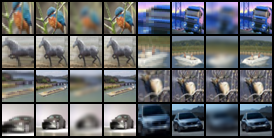

In [364]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


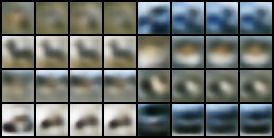

In [365]:
_, im = model(fixed_x)
save_image(im, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

In [366]:
for param in model.parameters():
    param.requires_grad = False

### Evaluation starts here

In [367]:
class Evaluate(nn.Module):
    def __init__(self):
        super(Evaluate, self).__init__()
        self.fc1 = nn.Linear(128, 10)
    
    def forward(self,vector):
        x = self.fc1(vector)
        return x

In [368]:
net = Evaluate()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net

Evaluate(
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

### Dataloader

In [369]:
trainset = torchvision.datasets.CIFAR10(root='.',transform = transforms.Compose([transforms.ToTensor()]),
                                        train=True,download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

Files already downloaded and verified


In [370]:
model.na = False

In [371]:
fixed_x, _ = next(iter(trainloader))

In [372]:
def evaluation(trainloader):
    epoch = 1
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data) in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()

        I_pool, _ = model(inputs)
        outputs = net(I_pool)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 10000:
            print('Step: [%5d] loss: %.3f' %(batch_idx + 1, loss.item()))
    
    print('Accuracy of the network: %d %%' % (100 * correct / total))

print('Finished Training')

Finished Training


In [373]:
evaluation(trainloader)

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Step: [    2] loss: 2.355
Step: [    3] loss: 2.271
Step: [    4] loss: 2.295
Step: [    5] loss: 2.296
Step: [    6] loss: 2.278
Step: [    7] loss: 2.267
Step: [    8] loss: 2.320
Step: [    9] loss: 2.341
Step: [   10] loss: 2.309
Step: [   11] loss: 2.286
Step: [   12] loss: 2.266
Step: [   13] loss: 2.260
Step: [   14] loss: 2.307
Step: [   15] loss: 2.280
Step: [   16] loss: 2.272
Step: [   17] loss: 2.335
Step: [   18] loss: 2.334
Step: [   19] loss: 2.308
Step: [   20] loss: 2.253
Step: [   21] loss: 2.305
Step: [   22] loss: 2.330
Step: [   23] loss: 2.262
Step: [   24] loss: 2.294
Step: [   25] loss: 2.311
Step: [   26] loss: 2.245
Step: [   27] loss: 2.262
Step: [   28] loss: 2.238
Step: [   29] loss: 2.296
Step: [   30] loss: 2.292
Step: [   31] loss: 2.254
Step: [   32] loss: 2.254
Step: [   33] loss: 2.249
Step: [   34] loss: 2.277
Step: [   35] loss: 2.277
Step: [   36] loss: 2.283
Step: [   37] loss: 2.245
Step: [   38] loss: 2.261
Step: [   39] loss: 2.310
Step: [   40

Step: [  330] loss: 2.019
Step: [  331] loss: 2.225
Step: [  332] loss: 2.079
Step: [  333] loss: 2.030
Step: [  334] loss: 2.018
Step: [  335] loss: 2.080
Step: [  336] loss: 2.100
Step: [  337] loss: 2.120
Step: [  338] loss: 2.183
Step: [  339] loss: 2.071
Step: [  340] loss: 2.223
Step: [  341] loss: 2.111
Step: [  342] loss: 2.081
Step: [  343] loss: 2.062
Step: [  344] loss: 2.172
Step: [  345] loss: 2.209
Step: [  346] loss: 2.052
Step: [  347] loss: 2.113
Step: [  348] loss: 2.077
Step: [  349] loss: 2.206
Step: [  350] loss: 2.185
Step: [  351] loss: 2.157
Step: [  352] loss: 2.142
Step: [  353] loss: 2.144
Step: [  354] loss: 2.100
Step: [  355] loss: 2.144
Step: [  356] loss: 2.052
Step: [  357] loss: 2.095
Step: [  358] loss: 2.136
Step: [  359] loss: 2.173
Step: [  360] loss: 2.107
Step: [  361] loss: 2.267
Step: [  362] loss: 2.096
Step: [  363] loss: 2.163
Step: [  364] loss: 2.122
Step: [  365] loss: 2.130
Step: [  366] loss: 2.153
Step: [  367] loss: 2.145
Step: [  368

Step: [  653] loss: 2.025
Step: [  654] loss: 2.070
Step: [  655] loss: 1.971
Step: [  656] loss: 1.930
Step: [  657] loss: 1.954
Step: [  658] loss: 1.907
Step: [  659] loss: 1.872
Step: [  660] loss: 1.981
Step: [  661] loss: 1.992
Step: [  662] loss: 1.997
Step: [  663] loss: 2.036
Step: [  664] loss: 2.035
Step: [  665] loss: 1.970
Step: [  666] loss: 2.066
Step: [  667] loss: 1.971
Step: [  668] loss: 1.998
Step: [  669] loss: 2.005
Step: [  670] loss: 2.029
Step: [  671] loss: 1.961
Step: [  672] loss: 1.989
Step: [  673] loss: 1.954
Step: [  674] loss: 2.062
Step: [  675] loss: 2.004
Step: [  676] loss: 1.866
Step: [  677] loss: 1.928
Step: [  678] loss: 2.138
Step: [  679] loss: 2.018
Step: [  680] loss: 2.064
Step: [  681] loss: 2.000
Step: [  682] loss: 2.064
Step: [  683] loss: 2.015
Step: [  684] loss: 2.110
Step: [  685] loss: 2.104
Step: [  686] loss: 2.010
Step: [  687] loss: 1.961
Step: [  688] loss: 2.016
Step: [  689] loss: 1.933
Step: [  690] loss: 1.995
Step: [  691

Step: [  978] loss: 2.006
Step: [  979] loss: 1.929
Step: [  980] loss: 1.978
Step: [  981] loss: 1.873
Step: [  982] loss: 2.122
Step: [  983] loss: 1.719
Step: [  984] loss: 1.916
Step: [  985] loss: 1.921
Step: [  986] loss: 1.897
Step: [  987] loss: 1.994
Step: [  988] loss: 2.122
Step: [  989] loss: 2.115
Step: [  990] loss: 1.825
Step: [  991] loss: 2.047
Step: [  992] loss: 1.929
Step: [  993] loss: 2.017
Step: [  994] loss: 1.982
Step: [  995] loss: 1.951
Step: [  996] loss: 1.907
Step: [  997] loss: 1.880
Step: [  998] loss: 1.980
Step: [  999] loss: 1.975
Step: [ 1000] loss: 1.885
Step: [ 1001] loss: 1.997
Step: [ 1002] loss: 1.867
Step: [ 1003] loss: 1.863
Step: [ 1004] loss: 1.940
Step: [ 1005] loss: 1.843
Step: [ 1006] loss: 1.834
Step: [ 1007] loss: 2.143
Step: [ 1008] loss: 1.844
Step: [ 1009] loss: 1.913
Step: [ 1010] loss: 2.093
Step: [ 1011] loss: 2.006
Step: [ 1012] loss: 1.837
Step: [ 1013] loss: 2.135
Step: [ 1014] loss: 1.854
Step: [ 1015] loss: 2.108
Step: [ 1016

Step: [ 1302] loss: 1.931
Step: [ 1303] loss: 1.875
Step: [ 1304] loss: 1.997
Step: [ 1305] loss: 2.064
Step: [ 1306] loss: 1.870
Step: [ 1307] loss: 1.986
Step: [ 1308] loss: 1.907
Step: [ 1309] loss: 1.940
Step: [ 1310] loss: 1.970
Step: [ 1311] loss: 1.849
Step: [ 1312] loss: 1.852
Step: [ 1313] loss: 2.006
Step: [ 1314] loss: 1.830
Step: [ 1315] loss: 1.881
Step: [ 1316] loss: 1.879
Step: [ 1317] loss: 2.232
Step: [ 1318] loss: 1.822
Step: [ 1319] loss: 2.040
Step: [ 1320] loss: 1.938
Step: [ 1321] loss: 1.891
Step: [ 1322] loss: 1.903
Step: [ 1323] loss: 1.749
Step: [ 1324] loss: 1.704
Step: [ 1325] loss: 1.767
Step: [ 1326] loss: 1.917
Step: [ 1327] loss: 1.893
Step: [ 1328] loss: 1.951
Step: [ 1329] loss: 2.033
Step: [ 1330] loss: 2.204
Step: [ 1331] loss: 1.988
Step: [ 1332] loss: 1.947
Step: [ 1333] loss: 1.880
Step: [ 1334] loss: 1.881
Step: [ 1335] loss: 1.917
Step: [ 1336] loss: 2.150
Step: [ 1337] loss: 2.012
Step: [ 1338] loss: 1.886
Step: [ 1339] loss: 2.051
Step: [ 1340